In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr 
#from statsmodels.tsa.stattools import acf
from sklearn import preprocessing
from collections import defaultdict
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.sparse import vstack, hstack, save_npz, load_npz
import json
#import seaborn as sns
import datetime
from scipy import stats

### t-Test (UE vs U)

In [39]:
from scipy import stats
res_user_probTopic = np.loadtxt('accuracies_model_user_probTopic.txt')
res_user_event = np.loadtxt('accuracies_model_user_event.txt')

print(np.mean(res_user_probTopic))
print(np.mean(res_user_event))
stats.ttest_ind(res_user_probTopic,res_user_event, equal_var = False)


0.7930429864253392
0.8227349641779789


Ttest_indResult(statistic=-178.39443797309235, pvalue=2.872732942747925e-223)

### Cohen's d (UE vs U)

In [40]:
def compute_cohen_d(top1, top50):
    cohens_d = (np.mean(top1) - np.mean(top50)) / (np.sqrt((np.std(top1) ** 2 + np.std(top50) ** 2) / 2))

    return cohens_d

print("Cohen's d ", compute_cohen_d(res_user_event, res_user_probTopic))

Cohen's d  17.8842103515039


### Number of posts per user samped during bootstrap

In [41]:
num_of_posts = np.loadtxt('num_posts_sample_user.txt')
S, U = num_of_posts.shape

for i in range(S):
    for j in range(U):
        if num_of_posts[i,j] < 17:
            print(i,j)

### Identifying users with positive feedback effect

No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


(200, 32345)
(200, 7072)
mean 0.6350779110852839
std 0.1339637934093019
[0.41831826 1.11443526 1.1950166  ... 1.21754638 0.88533524 1.26845975]
95 percentile score  2.0609207953064406
Number of users with positive FB 2450 0.3464366515837104
0.44314179994704284
Number of users with negative FB 96 0.013574660633484163
4526
Number of users that have neither pos or neg FB 4526 0.6399886877828054
Top pos users 0.3464366515837104


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


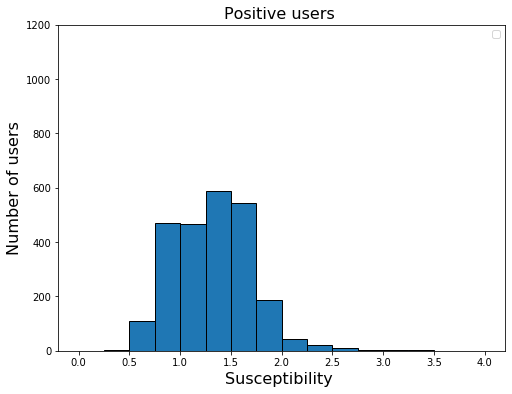

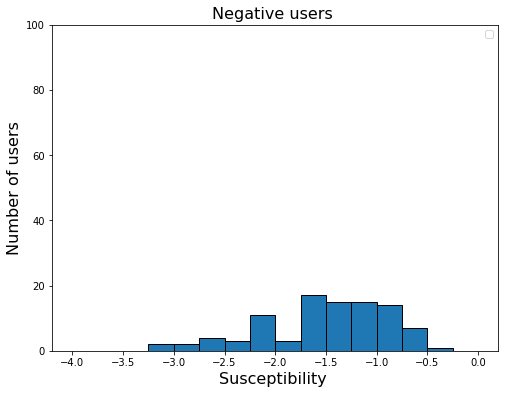

In [59]:
no_user = 7072 #10915
user_idx = no_user

def identifying_positive_users(feedback_defn):
    
    data_coef = load_npz('bootstraps_coefs_'+feedback_defn+'.npz')
    print(data_coef.shape)
    data_coef = data_coef.toarray()
    data = data_coef[:,:no_user]
    print(data.shape)


    median_fb = np.median(data, axis=0)
    mean_fb = np.mean(data, axis=0)

    print('mean', np.mean(mean_fb))
    print('std', 2.58*np.std(mean_fb)/np.sqrt(200))

    err_ci = (np.percentile(data, 99.5, axis=0)- np.percentile(data, 0.5, axis=0))/2.0
    print(err_ci)
    top_users_score = np.percentile(median_fb, 99)
    print('95 percentile score ', np.percentile(median_fb, 99))
    median_fb_pos = median_fb - err_ci
    median_fb_neg = median_fb + err_ci


    pos_fb_idx = np.where(median_fb_pos > 0.0)[0]
    no_with_pos_fb = len(pos_fb_idx)
    pos_fb = median_fb[pos_fb_idx]
    print('Number of users with positive FB', no_with_pos_fb, no_with_pos_fb/no_user)
    print(np.min(pos_fb))

    neg_fb_idx = np.where(median_fb_neg < 0.0)[0]
    no_with_neg_fb = len(neg_fb_idx)
    neg_fb = median_fb[neg_fb_idx]
    print('Number of users with negative FB', no_with_neg_fb, no_with_neg_fb/no_user)

    other_idx = list(set(list(range(no_user))) - (set(pos_fb_idx) | set(neg_fb_idx)))
    print(len(other_idx))
    no_others = no_user-no_with_pos_fb-no_with_neg_fb
    print('Number of users that have neither pos or neg FB',no_others, no_others/no_user)

    print('Top pos users', no_with_pos_fb/len(median_fb_pos))
    
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.ylim(0, 1200)
    plt.title("Positive users ", fontsize = 16)
    plt.hist(pos_fb, align='mid', cumulative=False, bins=16, range=(0,4.0), histtype='bar', ec='k')     
    #plt.ylabel('PDF', fontsize = 16)
    plt.ylabel('Number of users', fontsize = 16)
    plt.xlabel('Susceptibility ', fontsize = 16)
    plt.legend(loc='best')
    plt.savefig('reddit_'+feedback_defn+'_users_pos_no.eps', format='eps', dpi=1000)

    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.title("Negative users ", fontsize = 16)
    plt.ylim(0, 100)
    plt.hist(neg_fb, align='mid', cumulative=False, bins=16, range=(-4.0, 0), histtype='bar', ec='k')     
    #plt.ylabel('PDF', fontsize = 16)
    plt.ylabel('Number of users', fontsize = 16)
    plt.xlabel('Susceptibility ', fontsize = 16)
    plt.legend(loc='best')
    plt.savefig('reddit_'+feedback_defn+'_users_neg_no.eps', format='eps', dpi=1000)

    return pos_fb_idx, neg_fb_idx, other_idx, median_fb, median_fb_pos, median_fb_neg

pos_fb_idx, neg_fb_idx, other_idx, median_fb, median_fb_pos, median_fb_neg = identifying_positive_users('favdt')
#pos_fb_idx, neg_fb_idx, other_idx, median_fb, median_fb_pos, median_fb_neg = identifying_positive_users('pudt')


## Topic Trends

In [60]:
with open('top_100_byNoComments_outof_top1000_byNoSubscribers.csv', 'r') as f:
    subred_lines = f.readlines()

dict_id_subreddit = {}
for line in subred_lines:
    if not line.startswith('subreddit_id'):
        subred_data = line.strip().split(',')
        sub_id = subred_data[0]
        sub_name = subred_data[1]
        dict_id_subreddit[sub_id] = sub_name
        
with open('columnnames.txt', 'r') as f:
    col_lines = f.readlines()

dict_topicId_subId = {}
dict_subId_topicId = {}
k=0
for line in col_lines:
    if line.strip().startswith('topic'):
        sub_id = line[6:].strip()
        dict_topicId_subId[k] = sub_id
        dict_subId_topicId[sub_id] = k
        k+=1
        
print(dict_topicId_subId)

{0: 't5_2cneq', 1: 't5_2qh03', 2: 't5_2qh0u', 3: 't5_2qh13', 4: 't5_2qh16', 5: 't5_2qh1e', 6: 't5_2qh1i', 7: 't5_2qh1o', 8: 't5_2qh1q', 9: 't5_2qh1u', 10: 't5_2qh22', 11: 't5_2qh2p', 12: 't5_2qh33', 13: 't5_2qh3l', 14: 't5_2qh3s', 15: 't5_2qh4j', 16: 't5_2qh61', 17: 't5_2qh68', 18: 't5_2qh6c', 19: 't5_2qh6e', 20: 't5_2qh8e', 21: 't5_2qhcv', 22: 't5_2qhj4', 23: 't5_2qhl2', 24: 't5_2qhqb', 25: 't5_2qhwp', 26: 't5_2qhx4', 27: 't5_2qi4s', 28: 't5_2qi58', 29: 't5_2qi6d', 30: 't5_2qiel', 31: 't5_2qiep', 32: 't5_2qimj', 33: 't5_2qio8', 34: 't5_2qjvn', 35: 't5_2qka0', 36: 't5_2qlqh', 37: 't5_2qm7u', 38: 't5_2qm9d', 39: 't5_2qmeb', 40: 't5_2qmg3', 41: 't5_2qmlu', 42: 't5_2qn5f', 43: 't5_2qnts', 44: 't5_2qo4s', 45: 't5_2qq5c', 46: 't5_2qqjc', 47: 't5_2qstm', 48: 't5_2qt55', 49: 't5_2qzb6', 50: 't5_2r2jt', 51: 't5_2r2o9', 52: 't5_2r9po', 53: 't5_2r9vp', 54: 't5_2rawz', 55: 't5_2rfxx', 56: 't5_2rgs7', 57: 't5_2rh4c', 58: 't5_2rj3j', 59: 't5_2rjz2', 60: 't5_2rnve', 61: 't5_2rrlp', 62: 't5_2rxrw', 6

### Plot Topic trends from Inferred Parameters

No handles with labels found to put in legend.


(3, 25273)
21 [166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


44 [168, 169, 170, 171, 173, 46, 47, 48, 174, 175]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


59 [128, 129, 148, 149, 150, 154, 155, 156, 157, 158, 159, 162, 163, 164, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 127]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# topics with 3 consecutive positive betas  3
ukpolitics
nba
gameofthrones


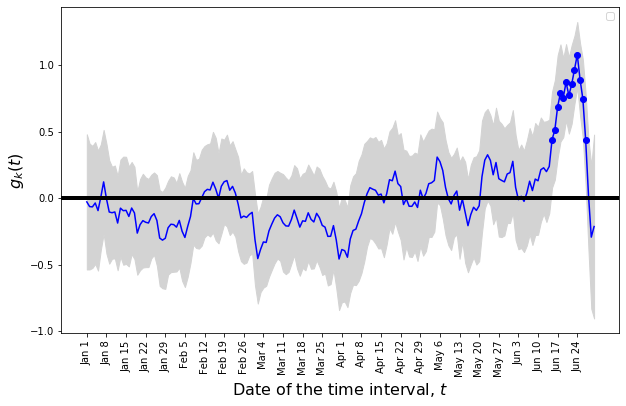

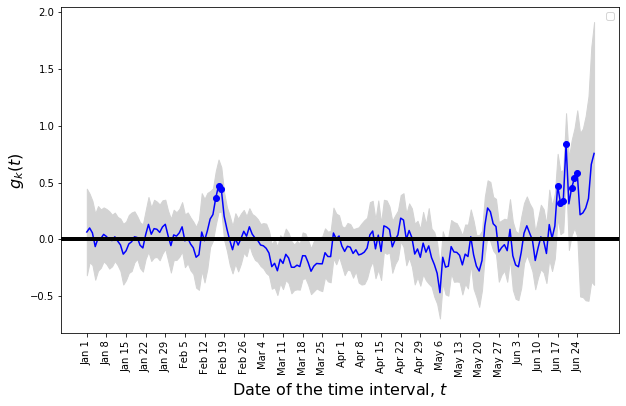

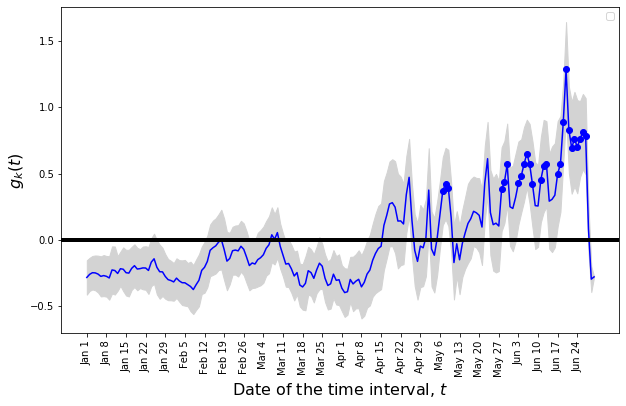

In [61]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)

no_user = 7072 #10921 
user_idx = no_user+1
j=0

data = np.loadtxt('model_parameters_model_user_eventmedian.txt')
res = data[0]
res_error =data[1]
print(data.shape)
no_topics = 100
topic_time_evt_matrix = res[user_idx:].flatten().reshape(no_topics, -1)
topic_time_evt_matrix_std = res_error[user_idx:].flatten().reshape(no_topics, -1)
topic_time_evt_matrix_std = topic_time_evt_matrix_std * 1.96/2.58
topic_time_evt_matrix = preprocessing.scale(topic_time_evt_matrix, axis=1, with_std=False)


jan = ['Jan '+str(i+1) for i in range(31)]
feb = ['Feb '+str(i+1) for i in range(29)]
mar = ['Mar '+str(i+1) for i in range(31)]
apr = ['Apr '+str(i+1) for i in range(30)]
may = ['May '+str(i+1) for i in range(31)]
jun = ['Jun '+str(i+1) for i in range(30)]

time_bins = np.array(jan+feb+mar+apr+may+jun)
x_bins = [k for k in range(182) if k%7==0]

imp_topics = [21, 44, 59]  # selected by comparing beta value with topic definition
topic_NoconsEvents = {}
no_topics_with_consEvts = 0
identified_subreddits = []
for top in imp_topics:
    
    res = topic_time_evt_matrix[top]
    N = len(res)
    error = topic_time_evt_matrix_std[top]

    res_min_error = res - error
    res_min_error[res_min_error<0] = 0
    
    result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
    topic_NoconsEvents[top] = len(result)
    
    
    if len(result) > 0:
        no_topics_with_consEvts+=1
        #print(top, np.array(result_idx)+1)
        j+=1
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)
        event_like_idxs = list(set(np.array(result_idx).flatten()))
        print(top, event_like_idxs)
    else:
        continue
    

    autocorr = pearsonr(res[:-1], res[1:])[0]
    #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

    minr = np.min(res)
    maxr = np.max(res)
    fig = plt.figure()
    fig.subplots_adjust(hspace=.50)
    fig.set_size_inches(10, 6)
    plt.subplot(1, 1, 1)
    identified_subreddits.append(dict_id_subreddit[dict_topicId_subId[top]])
    #plt.title('Subreddit: '+dict_id_subreddit[dict_topicId_subId[top]])
    #plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
    #plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)
    
    plt.ylabel(r'$g_k(t)$', fontsize = 16)
    plt.xlabel('Date of the time interval, 'r'$t$', fontsize = 16)

    time_intervals = np.array(list(range(N)))
    #plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
    plt.plot(time_intervals, res, linestyle='-', color='b')
    plt.plot(time_intervals[event_like_idxs], res[event_like_idxs], linestyle='None', marker='o', color='b')
    plt.fill_between(time_intervals, res-error, res+error, color='lightgrey')

    

    #plt.stem(list(range(N)), [0]*N, linestyle='-', marker='o', color='r')
    plt.axhline(linewidth=4, color='k')
    #plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
    #plt.plot([2,2], [minr-2, maxr+2], color='k')
    #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.xticks(x_bins, time_bins[x_bins])
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=27)
    plt.legend(loc='best')
    plt.savefig('reddit_ue_beta_topic'+str(top)+'.png', bbox_inches='tight')
    plt.savefig('reddit_ue_beta_topic'+str(top)+'.eps', format='eps', dpi=1000)
    


print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)
for sub in identified_subreddits:
    print(sub)                                            
#print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
#print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])

### Plot Topic trends from number of posts

No handles with labels found to put in legend.


100
21 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


44 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


59 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# topics with 3 consecutive positive betas  3
ukpolitics
nba
gameofthrones


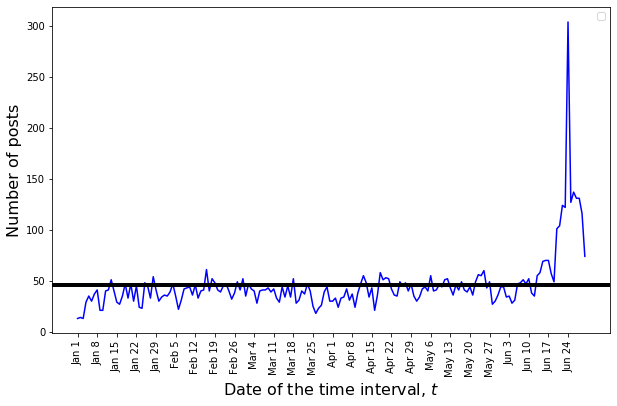

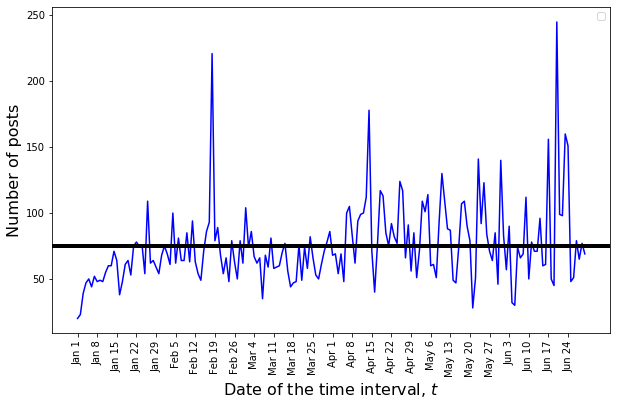

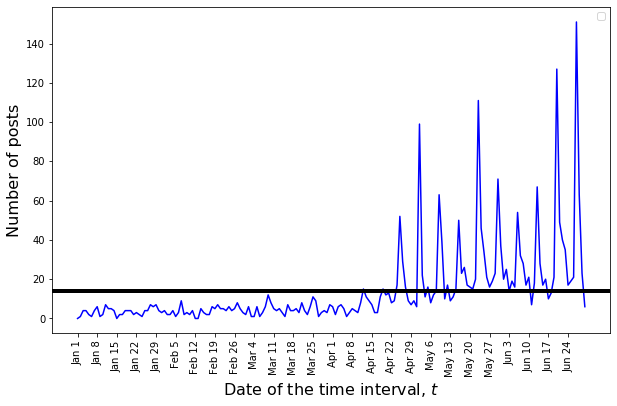

In [62]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)


with open('num_of_posts_by_timebin_topic.json', 'r') as fp:
    num_of_post_per_k_t = json.load(fp)
    
print(len(num_of_post_per_k_t))
    
topic_time_evt_matrix = np.zeros((100, 182))
for topic in num_of_post_per_k_t:
    for timebin in num_of_post_per_k_t[topic]:
        k, t = int(dict_subId_topicId[topic]), int(timebin)
        topic_time_evt_matrix[k][t] = num_of_post_per_k_t[topic][timebin]
        
        
topic_time_evt_matrix_mean = np.mean(topic_time_evt_matrix, axis=1)
#topic_time_evt_matrix = preprocessing.scale(topic_time_evt_matrix, axis=1, with_std=False)


jan = ['Jan '+str(i+1) for i in range(31)]
feb = ['Feb '+str(i+1) for i in range(29)]
mar = ['Mar '+str(i+1) for i in range(31)]
apr = ['Apr '+str(i+1) for i in range(30)]
may = ['May '+str(i+1) for i in range(31)]
jun = ['Jun '+str(i+1) for i in range(30)]

time_bins = np.array(jan+feb+mar+apr+may+jun)
x_bins = [k for k in range(182) if k%7==0]

imp_topics = [21, 44, 59]  # selected by comparing beta value with topic definition
topic_NoconsEvents = {}
no_topics_with_consEvts = 0
identified_subreddits = []
j=0
binc=1
for top in imp_topics:
    
    res = topic_time_evt_matrix[top]
    N = len(res)
    #error = topic_time_evt_matrix_std[top]

    res_min_error = res
    
    result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
    topic_NoconsEvents[top] = len(result)
    
    
    if len(result) > 0:
        no_topics_with_consEvts+=1
        #print(top, np.array(result_idx)+1)
        j+=1
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)
        event_like_idxs = list(set(np.array(result_idx).flatten()))
        print(top, event_like_idxs)
    else:
        continue
    

    autocorr = pearsonr(res[:-1], res[1:])[0]
    #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

    minr = np.min(res)
    maxr = np.max(res)
    fig = plt.figure()
    fig.subplots_adjust(hspace=.50)
    fig.set_size_inches(10, 6)
    plt.subplot(1, 1, 1)
    identified_subreddits.append(dict_id_subreddit[dict_topicId_subId[top]])
    #plt.title('Subreddit: '+dict_id_subreddit[dict_topicId_subId[top]])
    #plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
    #plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)
    
    plt.ylabel('Number of posts', fontsize = 16)
    plt.xlabel('Date of the time interval, 'r'$t$', fontsize = 16)

    time_intervals = np.array(list(range(N)))
    #plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
    plt.plot(time_intervals, res, linestyle='-', color='b')
    #plt.plot(time_intervals[event_like_idxs], res[event_like_idxs], linestyle='None', marker='o', color='b')
    #plt.fill_between(time_intervals, res-error, res+error, color='lightgrey')

    

    #plt.stem(list(range(N)), [0]*N, linestyle='-', marker='o', color='r')
    plt.axhline(y=topic_time_evt_matrix_mean[top], linewidth=4, color='k')
    #plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
    #plt.plot([2,2], [minr-2, maxr+2], color='k')
    #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.xticks(x_bins, time_bins[x_bins])
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=27)
    plt.legend(loc='best')
    plt.savefig('data_reddit_ue_beta_topic'+str(top)+'.png', bbox_inches='tight')
    plt.savefig('data_reddit_ue_beta_topic'+str(top)+'.eps', format='eps', dpi=1000)
    


print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)
for sub in identified_subreddits:
    print(sub)                                            
#print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
#print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])

### Difference in accuracy between Top 1% feedback and Top 50% feedback

No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(2, 7072)
0.020692639953128974 0.002023472932742133 0.0539531718292082
0.04885406398265415 0.004751386531856178 0.14025935218087066
median gain in probability 0.01047422753495001
fraction more than 10% 0.0326530612244898


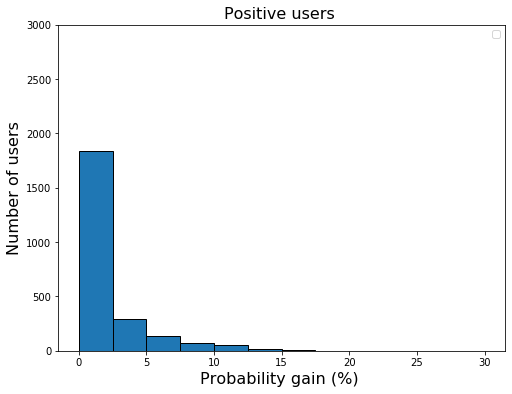

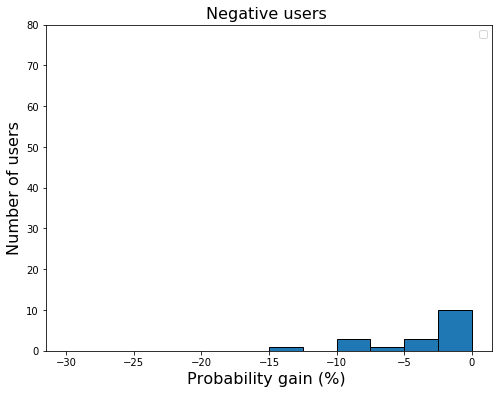

In [63]:
data = np.loadtxt('diff_in_prob_1_50.txt')
print(data.shape)
'''
with open('users_topics.json', 'r') as fp:
    users_topics = json.load(fp)
    
def compute_min_max_median(indexes):
    min_val = np.zeros(len(indexes))
    max_val = np.zeros(len(indexes))
    median_val = np.zeros(len(indexes))
    for i, u in enumerate(indexes):
        min_val[i] = np.min(data[u][users_topics[str(u)]])
        max_val[i] = np.max(data[u][users_topics[str(u)]])
        median_val[i] = np.median(data[u][users_topics[str(u)]])

    err_min_ci = (np.percentile(min_val, 99.5, axis=0)- np.percentile(min_val, 0.5, axis=0))/2.0
    err_max_ci = (np.percentile(max_val, 99.5, axis=0)- np.percentile(max_val, 0.5, axis=0))/2.0
    err_median_ci = (np.percentile(median_val, 99.5, axis=0)- np.percentile(median_val, 0.5, axis=0))/2.0
    print('median, min, err', np.median(min_val), err_min_ci)
    print('median, max, err', np.median(max_val), err_max_ci)
    print('median, median, err', np.median(median_val), err_median_ci)
    
print('positive users')
compute_min_max_median(pos_fb_idx)
print('negative users')
compute_min_max_median(neg_fb_idx)

'''

pos_fb = data[0][pos_fb_idx]
print(np.mean(pos_fb), np.std(pos_fb)/14, (np.percentile(pos_fb, 97.5, axis=0)- np.percentile(pos_fb, 2.5, axis=0))/2.0)
neg_fb = data[0][neg_fb_idx]
print(np.mean(neg_fb), np.std(neg_fb)/14, (np.percentile(neg_fb, 97.5, axis=0)- np.percentile(neg_fb, 2.5, axis=0))/2.0)

print('median gain in probability', np.median(pos_fb))
print('fraction more than 10%', len(np.where(pos_fb > 0.1)[0])/len(pos_fb))

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Positive users ", fontsize = 16)    
plt.ylim(0, 3000)
plt.hist(pos_fb*100, align='mid', cumulative=False, bins=12, range=(0,30), histtype='bar', ec='k')     
plt.ylabel('Number of users', fontsize = 16)
plt.xlabel('Probability gain (%) ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('reddit_diff_1_50_topFb_posUsers_no.eps', format='eps', dpi=1000)

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.ylim(0, 80)
plt.title("Negative users ", fontsize = 16)
plt.hist(neg_fb*100, align='mid', cumulative=False, bins=12, range=(-30,0.0), histtype='bar', ec='k')     
plt.ylabel('Number of users', fontsize = 16)
plt.xlabel('Probability gain (%) ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('reddit_diff_1_50_topFb_negUsers_no.eps', format='eps', dpi=1000)

### User feedback susceptibility with respect to users' number of posts

In [64]:
with open('columnnames.txt', 'r') as f:
    lines = f.readlines()
    
user_idxs = {}
k = 0
for line in lines:
    if line.startswith('user_user_'):
        user_idxs[int(line[10:].strip())] = k
        k+=1
        
print(len(user_idxs))
with open('username2id.json', 'r') as fp:
    username2id = json.load(fp)
    
with open('user_known_attributes.json', 'r') as fp:
    known_attrs = json.load(fp)
    
end_date = datetime.datetime.fromtimestamp(float('1467331199'))

with open('median_post_time.json', 'r') as fp:
    median_post_time = json.load(fp)

inter_arrival_times =  {}
for user in median_post_time:
    if int(user) in user_idxs:
        inter_arrival_times[user_idxs[int(user)]] = median_post_time[user]
'''
age_of_user = {}
user_karma = {}
for user in known_attrs:
    idx = username2id[user]
    if idx in user_idxs:
        u = user_idxs[idx]
        t_n = float(known_attrs[user][0])
        date_time = datetime.datetime.fromtimestamp(t_n)
        age = ((end_date - date_time ).total_seconds()) / 86400.0
        age_of_user[u] = age
        user_karma[u] = int(known_attrs[user][1])

'''
#user,AvgPerFb,SumFb, noPosts,noTopics
with open('user_attributes.csv', 'r') as f:
    lines =  f.readlines()
no_topics = {}
no_tweets = {}
for lin in lines[1:]:
    lin_data =  lin.strip().split(',')
    u_idx = int(lin_data[0][5:])
    if u_idx in user_idxs:
        u_id = user_idxs[u_idx]
        no_topics[u_id] = int(lin_data[-1])
        no_tweets[u_id] = int(lin_data[-2])
        
print(len(no_tweets))

7072
7072


No handles with labels found to put in legend.


(7072,)
[52.0, 71.0, 92.0, 139.0, 6141.0]
7072
#pos #neg, #insign : (759, 1, 1057)
#pos #neg, #insign %: (0.4177215189873418, 0.000550357732526142, 0.5817281232801321)


No handles with labels found to put in legend.


7072
#pos #neg, #insign : (626, 5, 1113)
#pos #neg, #insign %: (0.35894495412844035, 0.0028669724770642203, 0.6381880733944955)


No handles with labels found to put in legend.


7072
#pos #neg, #insign : (559, 9, 1180)
#pos #neg, #insign %: (0.3197940503432494, 0.005148741418764302, 0.6750572082379863)


No handles with labels found to put in legend.


7072
#pos #neg, #insign : (495, 81, 1173)
#pos #neg, #insign %: (0.2830188679245283, 0.04631217838765009, 0.6706689536878216)
percentile 0% 52.0
percentile 25% 71.0
percentile 50% 92.0
percentile 75% 139.0
percentile 100% 6141.0


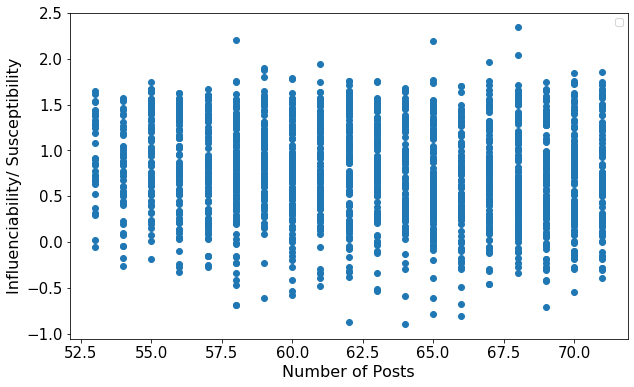

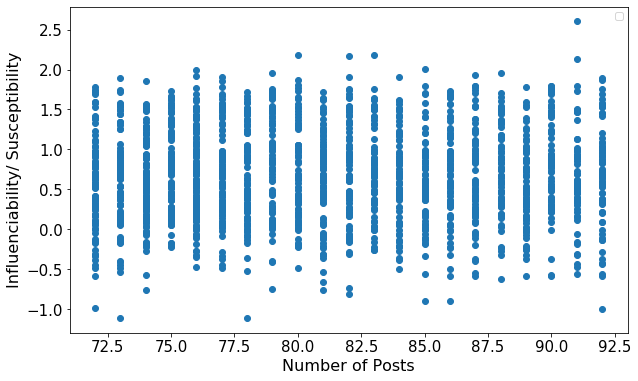

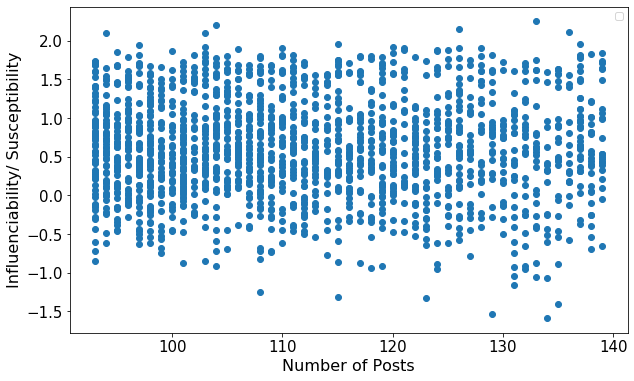

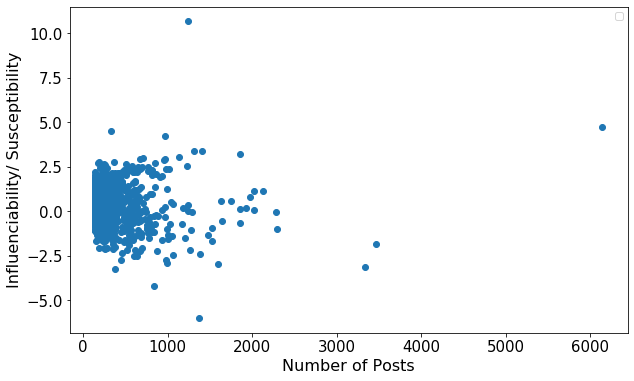

In [65]:
def plot_group_noPosts_and_alphas(median_fb, no_tweets, minPost, maxPost, label):
    alphas = []
    noPosts = []
    no_pos = 0
    no_neg = 0
    no_insg = 0
    
    print(len(no_tweets))
    for i in range(len(median_fb)):
        if no_tweets[i] > minPost and no_tweets[i] <= maxPost:
            alphas.append(median_fb[i])
            noPosts.append(no_tweets[i])
            
            if median_fb_pos[i] > 0: 
                no_pos +=1
            elif median_fb_neg[i] < 0:
                no_neg +=1
            else:
                no_insg +=1

    print('#pos #neg, #insign :', (no_pos, no_neg, no_insg))
    print('#pos #neg, #insign %:', (no_pos/len(noPosts), no_neg/len(noPosts), no_insg/len(noPosts)))
    
    fig = plt.figure()
    fig.set_size_inches(10, 6)
    plt.plot(noPosts, alphas, linestyle='None', marker='o')
    plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
    plt.xlabel('Number of Posts', fontsize = 16)
    plt.legend(loc='best')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.xticks(percentiles, percentile_est)
    plt.savefig(label+'.png', bbox_inches='tight')


no_posts_user = np.array(list(no_tweets.values()))

print(no_posts_user.shape)


per_scores = []
for perc in [0, 25, 50, 75, 100]:
    per_scores.append(np.percentile(no_posts_user, perc))
print(per_scores)
    
plot_group_noPosts_and_alphas(median_fb, no_tweets, per_scores[0], per_scores[1], label='reddit_group0_25_suscept')
plot_group_noPosts_and_alphas(median_fb, no_tweets, per_scores[1], per_scores[2], label='reddit_group25_50_suscept')
plot_group_noPosts_and_alphas(median_fb, no_tweets, per_scores[2], per_scores[3], label='reddit_group50_75_suscept')
plot_group_noPosts_and_alphas(median_fb, no_tweets, per_scores[3], per_scores[4], label='reddit_group75_100_suscept')


print('percentile 0%', np.percentile(no_posts_user, 0))
print('percentile 25%', np.percentile(no_posts_user, 25))
print('percentile 50%', np.percentile(no_posts_user, 50))
print('percentile 75%', np.percentile(no_posts_user, 75))
print('percentile 100%', np.percentile(no_posts_user, 100))

### Difference in accuracies: positive users, negative users and undetermined

[[ 0.00806405 -0.00050889  0.0013548 ]
 [ 0.00742233  0.00351344  0.00230809]
 [ 0.00732552  0.00342063  0.00282692]]
[[ 0.0010197  -0.0004197   0.00162815]
 [ 0.00196815  0.00031383  0.00080969]
 [ 0.00195554  0.00034381  0.00080579]]


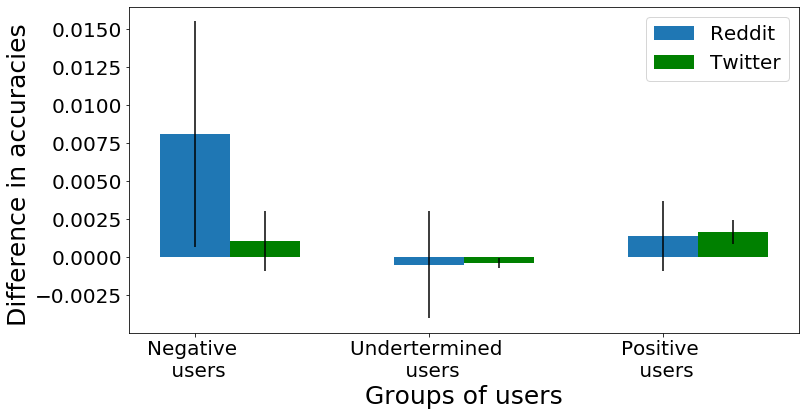

In [14]:
rd_diff_data = np.loadtxt('diff_in_accuracies_3groups.txt')
print(rd_diff_data)
rd_diff_mean = rd_diff_data[0]
rd_diff_ci = rd_diff_data[1]

tw_diff_data = np.loadtxt('../ModelEvent/diff_in_accuracies_3groups.txt')
tw_diff_mean = tw_diff_data[0]
tw_diff_ci = tw_diff_data[1]
print(tw_diff_data)

data_indexes = np.arange(3)

data_names = ['Negative \n users', 'Undertermined \n users','Positive \n users']

# Accuracy of models
fig = plt.figure()
#plt.style.use('seaborn')
#plt.grid(True)
fig.set_size_inches(12, 6)
#plt.title("Model 1: controlling for user")

baseline = 0.80
plt.bar(data_indexes+0.0, rd_diff_mean, yerr = rd_diff_ci, width = 0.3, align='center', label='Reddit')
plt.bar(data_indexes+0.3, tw_diff_mean, yerr = tw_diff_ci,  width = 0.3, align='center', color='g',label='Twitter')
#plt.bar(model_indexes, test_accuracies-baseline, bottom=baseline, align='center', ecolor='k')
        
plt.ylabel('Difference in accuracies ', fontsize = 25)
plt.xlabel('Groups of users', fontsize = 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(data_indexes, data_names)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('difference_in_accuracies_pos_neg_users.png', bbox_inches='tight')
#plt.savefig('user_event_feedback_model.eps', format='eps', dpi=1000)

### Number of Tweets vs fb

No handles with labels found to put in legend.


spearmanr cor(fb_est, pos_fb) 0.014059878731499048
spearmanr cor(fb_est, neg_fb) 0.16238039484839922
spearmanr cor(fb_est, other) 0.04584643107303813
pos  17.5967361111109 0.2671872113710512
neg  12.313888888888414 1.2818751318157033
insign  18.362569444444446 0.2486023972009362


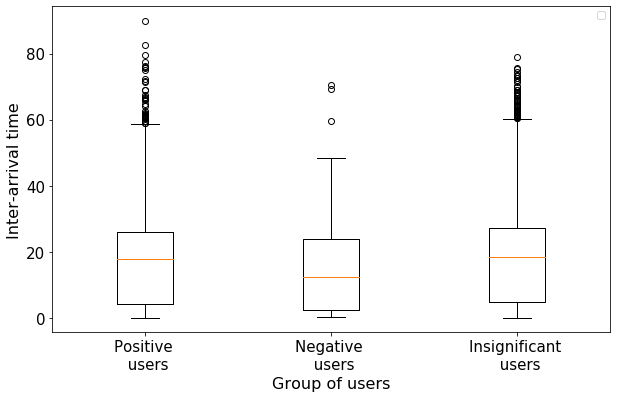

In [139]:
pos_fb_idx_ = list(set(pos_fb_idx) & set(inter_arrival_times.keys()))
followers_cnt_pos = np.array([inter_arrival_times[u_id]for u_id in pos_fb_idx_])*24

neg_fb_idx_ = list(set(neg_fb_idx) & set(inter_arrival_times.keys()))
followers_cnt_neg = np.array([inter_arrival_times[u_id]for u_id in neg_fb_idx_])*24

other_idx_ = list(set(other_idx) & set(inter_arrival_times.keys()))
followers_cnt_other = np.array([inter_arrival_times[u_id]for u_id in other_idx_])*24

pos_fb = median_fb[pos_fb_idx_]
neg_fb = median_fb[neg_fb_idx_]
other_fb = median_fb[other_idx_]


print('spearmanr cor(fb_est, pos_fb)', spearmanr(pos_fb, followers_cnt_pos)[0])
print('spearmanr cor(fb_est, neg_fb)', spearmanr(neg_fb, followers_cnt_neg)[0])
print('spearmanr cor(fb_est, other)', spearmanr(other_fb, followers_cnt_other)[0])


print('pos ', np.median(followers_cnt_pos), 1.253*np.std(followers_cnt_pos)/np.sqrt(len(followers_cnt_pos)))
print('neg ', np.median(followers_cnt_neg), 1.253*np.std(followers_cnt_neg)/np.sqrt(len(followers_cnt_neg)))
print('insign ', np.median(followers_cnt_other), 1.253*np.std(followers_cnt_other)/np.sqrt(len(followers_cnt_other)))

plot_data = [followers_cnt_pos, followers_cnt_neg, followers_cnt_other]

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.ylabel('Inter-arrival time', fontsize = 16)
plt.xlabel('Group of users', fontsize = 16)
plt.boxplot(plot_data)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(list(range(1,4)), ['Positive \n users', 'Negative \n users',  'Insignificant \n users'])
plt.savefig('reddit_inter_arrival_time.png', bbox_inches='tight')

### Scattered plot between feedback estimate $\alpha_i$ and age of account

No handles with labels found to put in legend.


spearmanr cor(fb_est, pos_fb) -0.0850328324071099
spearmanr cor(fb_est, neg_fb) -0.6974457521840262
spearmanr cor(fb_est, other) -0.005953518667564669
pos  50137.7757385855 4335.663657796665
neg  4.5 19212.7750275374
insign  14994.5 9450.290885886376


No handles with labels found to put in legend.
No handles with labels found to put in legend.


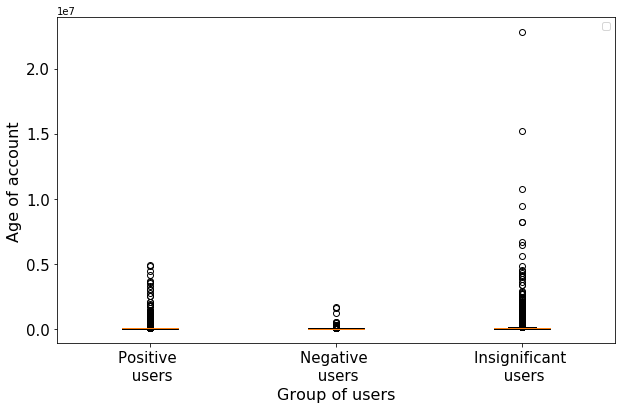

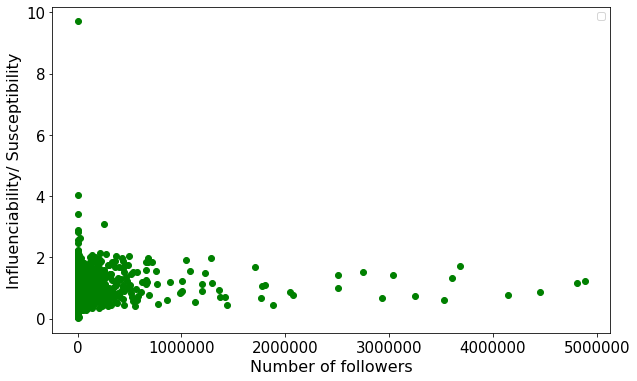

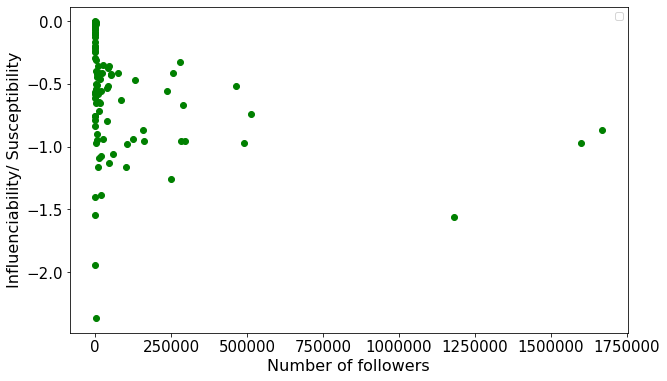

In [141]:
pos_fb_idx_ = list(set(pos_fb_idx) & set(user_karma.keys()))
followers_cnt_pos = [user_karma[u_id]for u_id in pos_fb_idx_]

neg_fb_idx_ = list(set(neg_fb_idx) & set(user_karma.keys()))
followers_cnt_neg = [user_karma[u_id]for u_id in neg_fb_idx_]

other_idx_ = list(set(other_idx) & set(user_karma.keys()))
followers_cnt_other = [user_karma[u_id]for u_id in other_idx_]

pos_fb = median_fb[pos_fb_idx_]
neg_fb = median_fb[neg_fb_idx_]
other_fb = median_fb[other_idx_]


print('spearmanr cor(fb_est, pos_fb)', spearmanr(pos_fb, followers_cnt_pos)[0])
print('spearmanr cor(fb_est, neg_fb)', spearmanr(neg_fb, followers_cnt_neg)[0])
print('spearmanr cor(fb_est, other)', spearmanr(other_fb, followers_cnt_other)[0])


print('pos ', np.mean(followers_cnt_pos), 1.253*np.std(followers_cnt_pos)/np.sqrt(len(followers_cnt_pos)))
print('neg ', np.median(followers_cnt_neg), 1.253*np.std(followers_cnt_neg)/np.sqrt(len(followers_cnt_neg)))
print('insign ', np.median(followers_cnt_other), 1.253*np.std(followers_cnt_other)/np.sqrt(len(followers_cnt_other)))


plot_data = [followers_cnt_pos, followers_cnt_neg, followers_cnt_other]

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.ylabel('Age of account', fontsize = 16)
plt.xlabel('Group of users', fontsize = 16)
plt.boxplot(plot_data)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(list(range(1,4)), ['Positive \n users', 'Negative \n users',  'Insignificant \n users'])
plt.savefig('reddit_ageofaccount.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_pos, pos_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of followers', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('reddit_cor_age_alpha_pos.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_neg, neg_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of followers', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('reddit_cor_age_alpha_neg.png', bbox_inches='tight')

### Scattered plot between feedback estimate $\alpha_i$ and user coefficient $a_i$

No handles with labels found to put in legend.


pearsonr cor(fb_est, user_est) 0.6062769614332719


No handles with labels found to put in legend.


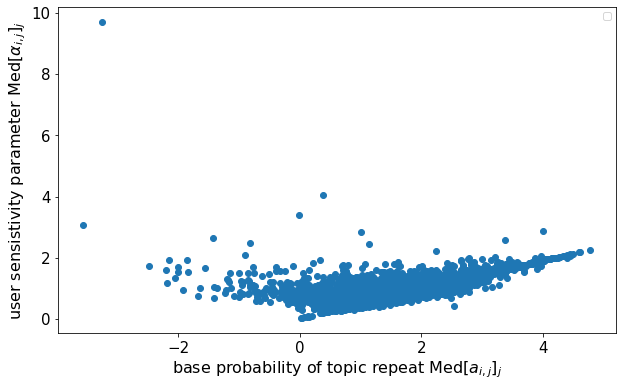

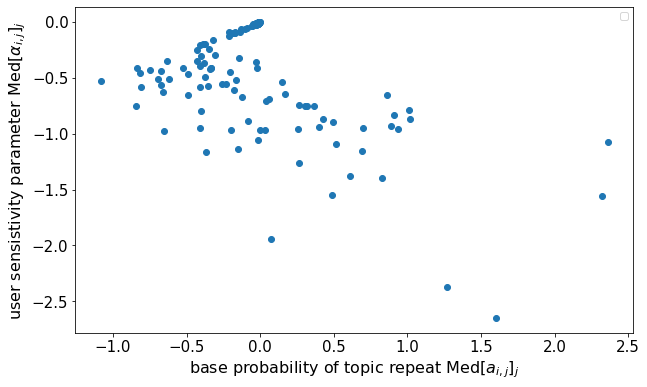

In [142]:
no_user = 10921
data = np.median(data_coef, axis=0) #np.loadtxt('model_parameters_model_user_event_fb_pumedian.txt')
fb_est = data[:no_user]
user_est = data[no_user+1:2*no_user+1]

fb_est_pos = fb_est[pos_fb_idx]
user_est_pos = user_est[pos_fb_idx]


fb_est_neg = fb_est[neg_fb_idx]
user_est_neg = user_est[neg_fb_idx]

print('pearsonr cor(fb_est, user_est)', pearsonr(fb_est_pos, user_est_pos)[0])


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(user_est_pos, fb_est_pos, linestyle='None', marker='o')
plt.ylabel('user sensistivity parameter 'r'${\rm Med}[\alpha_{i, j}]_j$', fontsize = 16)
plt.xlabel('base probability of topic repeat 'r'${\rm Med}[a_{i, j}]_j$', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('reddit_cor_feedback_user_property_pos.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(user_est_neg, fb_est_neg, linestyle='None', marker='o')
plt.ylabel('user sensistivity parameter 'r'${\rm Med}[\alpha_{i, j}]_j$', fontsize = 16)
plt.xlabel('base probability of topic repeat 'r'${\rm Med}[a_{i, j}]_j$', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('reddit_cor_feedback_user_property_neg.png', bbox_inches='tight')

## Difference in Accuracy for users between model UEF and model UE

In [144]:
data = np.loadtxt('diff_in_accuracies_perUserPercentile_pu.txt')[:,:-1]
percentile_est = data[0]
percentile_std = data[1]
diff_in_acc_mean = data[2]
diff_in_acc_ci = data[3]
diff_in_acc_std = data[4]
percentiles = list(range(0,100,5))
print(len(percentiles), len(percentile_est))

20 2


No handles with labels found to put in legend.


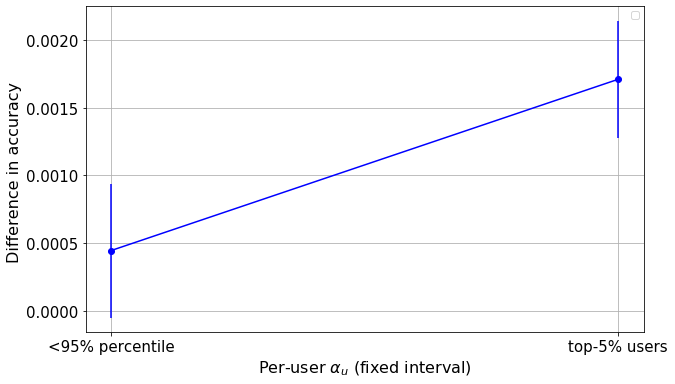

In [145]:
sqr_nRuns=1
bins_idxes = list(range(2))
#bins_alpha_u = ['<-1.0', '[-1.0, \n -0.8]', '[-0.8, \n -0.6]', '[-0.6, \n -0.4]', '[-0.4, \n -0.2]',
#               '[-0.2, \n 0.0]', '[0.0, \n 0.2]', '[0.2, \n 0.4]','[0.4, \n 0.6]', '[0.6, \n 0.8]',
#               '[0.8, \n 1.0]', '>1.0']
bins_alpha_u = ['<95% percentile', 'top-5% users']
fig = plt.figure()
fig.set_size_inches(10, 6)
#plt.title('Difference between test accuracy and \n test accuracy obtained by setting ' r'$\alpha_u$' ' in a percentile bin to zero')
plt.errorbar(bins_idxes, diff_in_acc_mean, yerr=diff_in_acc_std/10, linestyle='-', marker='o', color='b', ecolor='b')
plt.ylabel('Difference in accuracy ', fontsize = 16)
plt.xlabel('Per-user 'r'$\alpha_u$' ' (fixed interval)', fontsize = 16)
plt.legend(loc='best')
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(bins_idxes, bins_alpha_u)
#plt.xticks(percentiles, percentile_est)
plt.savefig('reddit_diff_in_accuracy_pu.png', bbox_inches='tight')

## Distribution of the feedback estimate across users

No handles with labels found to put in legend.


(40143,)
Non-zero features:  39901
40143
[-4.56834306 -4.3355742  -3.79267442 ...  1.94142367  1.95481066
  2.14646838]
# users with non Zero (significant) effect size  756
average alpha  0.40325748298703085


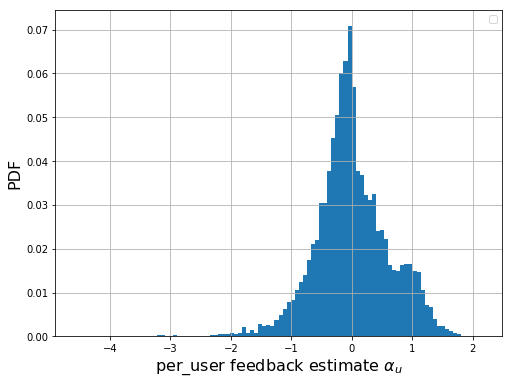

In [17]:
no_user = 10948
user_idx = no_user + 1
j=0

data = np.loadtxt('model_parameters_model_user_event_fb_pu.txt')
res = data[0]
print(res.shape)
res_error = data[1]
binc=1
print('Non-zero features: ', len(np.where(res!=0)[0]))
N = len(res)
print(N)


alphas_u = res[0:no_user]
alphas_u_err = res_error[0:no_user]

np.savetxt('userTreatment_error.txt', alphas_u_err)
alphas_u_plus_error = alphas_u - alphas_u_err
print(np.sort(alphas_u_plus_error))
nonZero = np.where(alphas_u_plus_error >= 1.0)[0]

print('# users with non Zero (significant) effect size ', len(nonZero))
print('average alpha ', np.mean(alphas_u))

fig = plt.figure()
fig.set_size_inches(8, 6)
#plt.title("Distribution of the impact of Feedback for different users")

#plt.errorbar(range(7210), alphas_u, yerr = alphas_u_err, linestyle='-', marker='o', color='b',  ecolor='c')
#plt.hist(alphas_u_plus_error, align='mid', cumulative=False, bins='auto')     
plt.hist(alphas_u_plus_error, align='mid', cumulative=False, weights=np.ones(len(alphas_u_plus_error)) / len(alphas_u_plus_error), bins=100)     
plt.ylabel('PDF', fontsize = 16)
plt.xlabel('per_user feedback estimate ' r'$\alpha_u$', fontsize = 16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('reddit_feedback_different_users_pu.png', bbox_inches='tight')

### Correlation between $\alpha_u$ and user attributes

In [18]:
with open('columnnames.txt') as f1:
    col_lines = f1.readlines()
    
user_cols = []
for col in col_lines:
    if col.startswith('user_'):
        user_n = col.strip()
        user_cols.append(user_n[5:])
        
print(len(user_cols))
with open('user_attributes.csv') as f:
    lines = f.readlines()

user_attrs = defaultdict(list)
for attr_line in lines[1:]:
    user, avf_nfb, nfb, npost, ntopics = attr_line.strip().split(',')
    user_attrs[user] = [float(avf_nfb), float(npost), float(ntopics), float(nfb)]

fb_seq = []
npost_seq = []
ntopic_seq = []
fb_alphas = alphas_u

sum_fb_seq = []
for user in user_cols:
    fb_seq.append(user_attrs[user][0])
    npost_seq.append(user_attrs[user][1])
    ntopic_seq.append(user_attrs[user][2])
    sum_fb_seq.append(user_attrs[user][3])
    
from scipy.stats import pearsonr
from scipy.stats import spearmanr
print('pearsonr cor(alpha_u, nFb)', pearsonr(fb_alphas, np.array(fb_seq))[0])

print('pearsonr cor(alpha_u, sum_nFb)', pearsonr(fb_alphas, np.array(sum_fb_seq))[0])

print('pearsonr cor(alpha_u, nPost)', pearsonr(fb_alphas, np.array(npost_seq))[0])

print('pearsonr cor(alpha_u, nTopics)', pearsonr(fb_alphas, np.array(ntopic_seq))[0])

10948
pearsonr cor(alpha_u, nFb) 0.013223389161548816
pearsonr cor(alpha_u, sum_nFb) -0.007299957280619416
pearsonr cor(alpha_u, nPost) 0.0034015501945455504
pearsonr cor(alpha_u, nTopics) 0.0011177427960494615


### Distribution of users' attributes: #FB, #Topics, #Posts

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


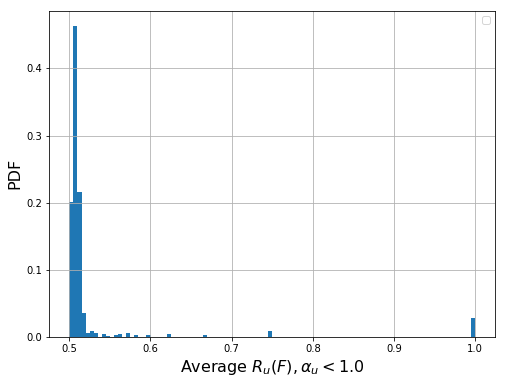

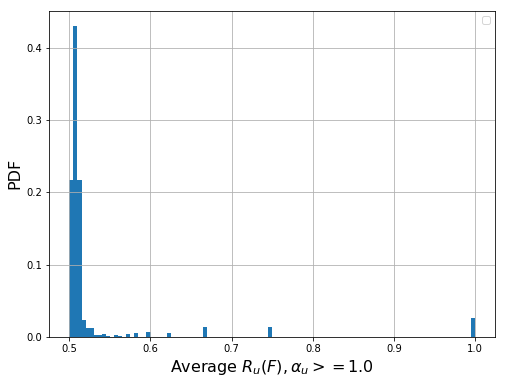

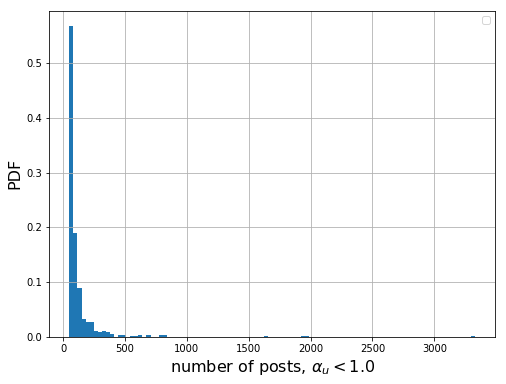

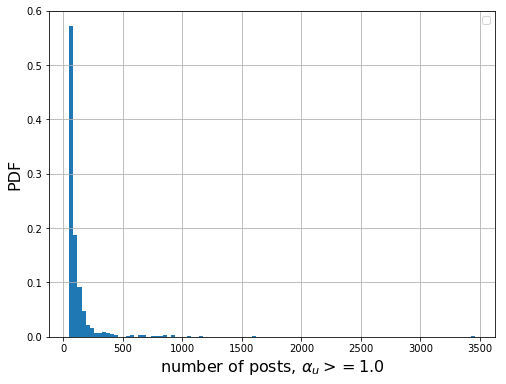

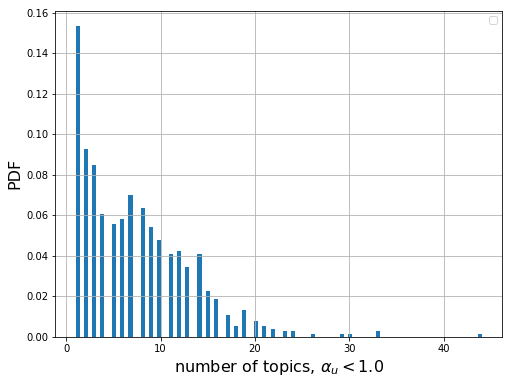

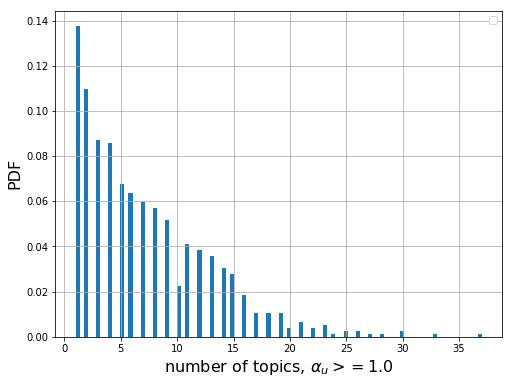

In [19]:
fig = plt.figure()
fig.set_size_inches(8, 6)
n_seq = np.array(fb_seq)[~nonZero]
plt.hist(n_seq, align='mid', cumulative=False, weights=np.ones(len(n_seq)) / len(n_seq), bins=100)     
plt.ylabel('PDF', fontsize = 16)
plt.xlabel('Average ' r'$R_u(F), \alpha_u < 1.0$', fontsize = 16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('reddit_distribution_fb_less1.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(8, 6)
n_seq = np.array(fb_seq)[nonZero]
plt.hist(n_seq, align='mid', cumulative=False, weights=np.ones(len(n_seq)) / len(n_seq), bins=100)     
plt.ylabel('PDF', fontsize = 16)
plt.xlabel('Average ' r'$R_u(F), \alpha_u >= 1.0$', fontsize = 16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('reddit_distribution_fb_more1.png', bbox_inches='tight')

############################

fig = plt.figure()
fig.set_size_inches(8, 6)
n_seq = np.array(npost_seq)[~nonZero]
plt.hist(n_seq, align='mid', cumulative=False, weights=np.ones(len(n_seq)) / len(n_seq), bins=100)     
plt.ylabel('PDF', fontsize = 16)
plt.xlabel('number of posts, ' r'$\alpha_u < 1.0$', fontsize = 16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('reddit_distribution_posts_less1.png', bbox_inches='tight')

fig = plt.figure()
fig.set_size_inches(8, 6)
n_seq = np.array(npost_seq)[nonZero]
plt.hist(n_seq, align='mid', cumulative=False, weights=np.ones(len(n_seq)) / len(n_seq), bins=100)     
plt.ylabel('PDF', fontsize = 16)
plt.xlabel('number of posts, ' r'$\alpha_u >= 1.0$', fontsize = 16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('reddit_distribution_posts_more1.png', bbox_inches='tight')

###############################
fig = plt.figure()
fig.set_size_inches(8, 6)
n_seq = np.array(ntopic_seq)[~nonZero]
plt.hist(n_seq, align='mid', cumulative=False, weights=np.ones(len(n_seq)) / len(n_seq), bins=100)     
plt.ylabel('PDF', fontsize = 16)
plt.xlabel('number of topics, 'r'$\alpha_u < 1.0$', fontsize = 16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('reddit_distribution_topics_less1.png', bbox_inches='tight')

fig = plt.figure()
fig.set_size_inches(8, 6)
n_seq = np.array(ntopic_seq)[nonZero]
plt.hist(n_seq, align='mid', cumulative=False, weights=np.ones(len(n_seq)) / len(n_seq), bins=100)     
plt.ylabel('PDF', fontsize = 16)
plt.xlabel('number of topics, 'r'$\alpha_u >= 1.0$', fontsize = 16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('reddit_distribution_topics_more1.png', bbox_inches='tight')


In [20]:
with open('top_100_subreddits.csv', 'r') as f:
    subred_lines = f.readlines()

dict_id_subreddit = {}
for line in subred_lines:
    if not line.startswith('subreddit_id'):
        subred_data = line.strip().split(',')
        sub_id = subred_data[0]
        sub_name = subred_data[1]
        dict_id_subreddit[sub_id] = sub_name
        
with open('columnnames.txt', 'r') as f:
    col_lines = f.readlines()

dict_topicId_subId = {}
k=0
for line in col_lines:
    if line.strip().startswith('topic'):
        sub_id = line[6:].strip()
        dict_topicId_subId[k] = sub_id
        k+=1
    
    

### Delay Distribution for Reddit

In [22]:
data = np.loadtxt('delays_dist.csv') * 24 *60  #* (24*60*60)
data = data[np.where((data>0))[0]]
data_1_1000 = data[np.where((data>=0) & (data<=1000) )[0]]
print( '% of pairs of tweets with delay between 0 mins to 1000mins: ', float(len(data_1_1000))/float(len(data)))

% of pairs of tweets with delay between 0 mins to 1000mins:  0.8561888492001863


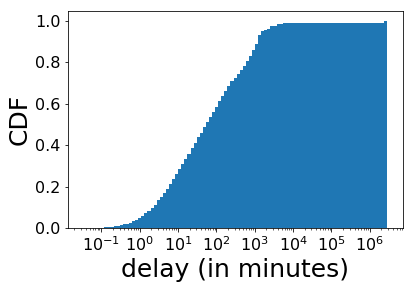

In [23]:
fig = plt.figure()
#plt.style.use('seaborn')
ax = fig.add_subplot(111)
n_bins=100
bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), num=n_bins)
plt.hist(data, bins=bins, align='mid', cumulative=True, weights=np.ones(len(data)) / len(data))
#plt.yscale('log')
plt.xscale('log')
#ax.set_title('Distribution of the delay between a pair of tweets',fontsize= 20)
ax.set_xlabel('delay (in minutes)',fontsize = 25)
ax.set_ylabel('CDF', fontsize = 25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('reddit_dist_delay_mins.png', bbox_inches='tight')

### Average number of comments

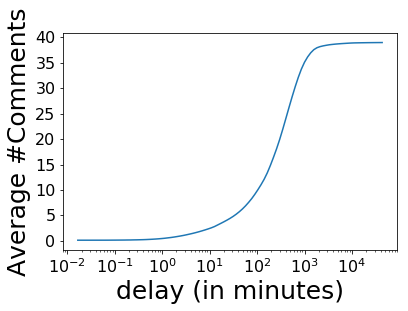

In [24]:
data = np.genfromtxt('avg_nComments_delay_weighted.csv',delimiter=',',dtype=None)
# ignore the last delay with np.inf
delays = data[0][:-1] * 24 *60
avgRT = data[1][:-1]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xscale('log')
#ax.set_title('Average #RT as delay between tweets increases',fontsize= 20)
ax.set_xlabel('delay (in minutes)',fontsize = 25)
ax.set_ylabel('Average #Comments', fontsize = 25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(delays, avgRT )
plt.savefig('reddit_avgNRT_mins.png', bbox_inches='tight')


## Comparing different ways of measuring feedback

In [25]:
reddit_df = pd.read_csv('feature_importance_user.csv')
#reddit_df = reddit_df.drop([0, 1, 3 ,5])
reddit_df = reddit_df.loc[[2,6,4,7]]
reddit_df

Unnamed: 0  best param C  best param D  test_accuracy  \
2    model_user_probTopic          1.00           0.0       0.841071   
6        model_user_fb_pu          1.00           0.0       0.839902   
4        model_user_event          0.01          10.0       0.859187   
7  model_user_event_fb_pu          0.10          10.0       0.859780   

   test_accuracy_error  test_acc_ci_error  
2             0.001215           0.001211  
6             0.003863           0.001197  
4             0.003114           0.003022  
7             0.002846           0.002963

In [26]:
tweet_df = pd.read_csv('../ModelEvent/feature_importance_user.csv')
#tweet_df = tweet_df.drop([0,1, 3 ,5])
tweet_df = tweet_df.loc[[2,6,4,7]]
tweet_df

Unnamed: 0  best param C  best param D  test_accuracy  \
2    model_user_probTopic           1.0           0.0       0.815484   
6        model_user_fb_pu           1.0           0.0       0.815902   
4        model_user_event           0.1          10.0       0.834944   
7  model_user_event_fb_pu           0.1          10.0       0.834946   

   test_accuracy_error  test_acc_ci_error  
2             0.000649           0.000616  
6             0.000618           0.000630  
4             0.000856           0.000682  
7             0.003641           0.000732

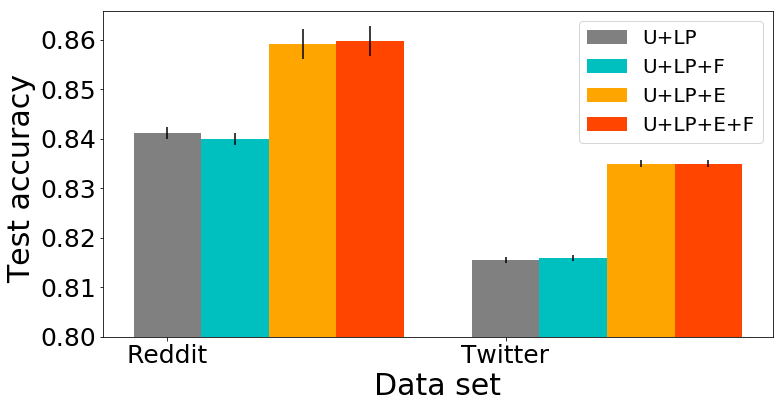

In [73]:
red_accuracies = reddit_df['test_accuracy'].values
red_acc_error = reddit_df['test_acc_ci_error'].values

tw_accuracies = tweet_df['test_accuracy'].values
tw_acc_error = tweet_df['test_acc_ci_error'].values

u_lp = np.array([red_accuracies[0], tw_accuracies[0]])
u_lp_f = np.array([red_accuracies[1], tw_accuracies[1]])
u_lp_e = np.array([red_accuracies[2], tw_accuracies[2]])
u_lp_e_f = np.array([red_accuracies[3], tw_accuracies[3]])

err_u_lp = np.array([red_acc_error[0], tw_acc_error[0]])
err_u_lp_f = np.array([red_acc_error[1], tw_acc_error[1]])
err_u_lp_e = np.array([red_acc_error[2], tw_acc_error[2]])
err_u_lp_e_f = np.array([red_acc_error[3], tw_acc_error[3]])


data_indexes = np.arange(2)
#model_names = ['F','F'r'$\Delta t$', 'FU'r'$\Delta t$', 'FT'r'$\Delta t$', 'FE'r'$\Delta t$',
#               'FUT'r'$\Delta t$', 'FUE'r'$\Delta t$', 'FTE'r'$\Delta t$', 'FTUE'r'$\Delta t$']

#model_names = ['U+LP', 'U+LP+'r'$R_u(F)$', 'U+LP+E', 'U+LP+ E+' r'$R_u(F)$']
data_names = ['Reddit', 'Twitter']

# Accuracy of models
fig = plt.figure()
#plt.style.use('seaborn')
#plt.grid(True)
fig.set_size_inches(12, 6)
#plt.title("Model 1: controlling for user")

baseline = 0.80
plt.bar(data_indexes+0.0, u_lp-baseline, yerr = err_u_lp, bottom = baseline, width = 0.2, align='center', color='grey', label='U+LP')
plt.bar(data_indexes+0.2, u_lp_f-baseline, yerr = err_u_lp_f, bottom=baseline, width = 0.2, align='center', color='c',label='U+LP+F')
plt.bar(data_indexes+0.4, u_lp_e-baseline, yerr = err_u_lp_e, bottom=baseline, width = 0.2, align='center', color='orange',label='U+LP+E')
plt.bar(data_indexes+0.6, u_lp_e_f-baseline, yerr = err_u_lp_e_f, bottom=baseline, width = 0.2, align='center', color='orangered',label='U+LP+E+F')

#plt.bar(model_indexes, test_accuracies-baseline, bottom=baseline, align='center', ecolor='k')
        
plt.ylabel('Test accuracy ', fontsize = 30)
plt.xlabel('Data set', fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(data_indexes, data_names)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('user_event_feedback_model.png', bbox_inches='tight')
#plt.savefig('user_event_feedback_model.eps', format='eps', dpi=1000)

### Importance of modeling events

ValueError: In safezip, len(args[0])=5 but len(args[1])=1

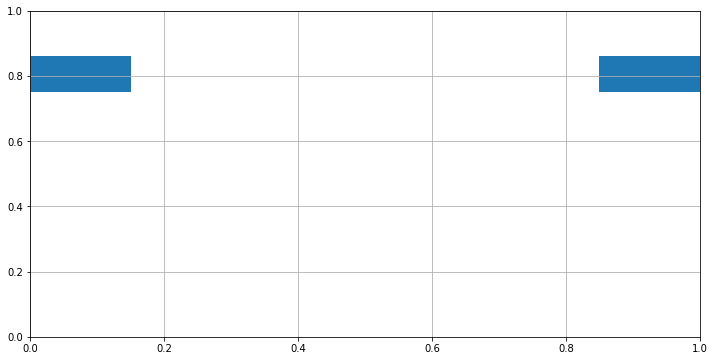

In [15]:
red_accuracies = reddit_df['test_accuracy'][3:8]
red_acc_error = reddit_df['test_accuracy_error'][3:8]

tw_accuracies = tweet_df['test_accuracy'][3:8]
tw_acc_error = tweet_df['test_accuracy_error'][3:8]
model_indexes = np.arange(5)
#model_names = ['F','F'r'$\Delta t$', 'FU'r'$\Delta t$', 'FT'r'$\Delta t$', 'FE'r'$\Delta t$',
#               'FUT'r'$\Delta t$', 'FUE'r'$\Delta t$', 'FTE'r'$\Delta t$', 'FTUE'r'$\Delta t$']

model_names = ['UR', 'URE', 'URF \n F' , 'URF \n'r'$P_u (F)$', 'URF \n' r'$P_{u,t}(F)$']

#model_names = ['U', 'UE', 'UF \n'r'$P_{u,t}(F)$' , 'UF \n'r'$P_u (F/t)$', 'UEF \n' r'$P_{u,t}(F)$', 'UEF \n F', 'UEF \n F/t', 'UEF \n' r'$P_u(F/t)$', 
#              'UEF \n' r'$P_u(F)$']

# Accuracy of models
fig = plt.figure()
#plt.style.use('seaborn')
plt.grid(True)
fig.set_size_inches(12, 6)
#plt.title("Model 1: controlling for user")

baseline = 0.75
plt.bar(model_indexes+0.0, red_accuracies-baseline, yerr = red_acc_error, bottom = baseline, width = 0.30, align='center', ecolor='k', label='Reddit')
plt.bar(model_indexes+0.3, tw_accuracies-baseline, yerr = tw_acc_error, bottom=baseline, width = 0.30, align='center', ecolor='k',label='Twitter')

#plt.bar(model_indexes, test_accuracies-baseline, bottom=baseline, align='center', ecolor='k')
        
plt.ylabel('Test accuracy ', fontsize = 30)
plt.xlabel('Model names', fontsize = 30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.xticks(model_indexes, model_names)
plt.legend(loc='best')
plt.savefig('imp_event.png', bbox_inches='tight')

### Modeling events and feedback

In [ ]:
cons_idxs = [3,4]+[8,9,10]
red_accuracies = reddit_df['test_accuracy'][cons_idxs]
red_acc_error = reddit_df['test_accuracy_error'][cons_idxs]

tw_accuracies = tweet_df['test_accuracy'][cons_idxs]
tw_acc_error = tweet_df['test_accuracy_error'][cons_idxs]
model_indexes = np.arange(5)
#model_names = ['F','F'r'$\Delta t$', 'FU'r'$\Delta t$', 'FT'r'$\Delta t$', 'FE'r'$\Delta t$',
#               'FUT'r'$\Delta t$', 'FUE'r'$\Delta t$', 'FTE'r'$\Delta t$', 'FTUE'r'$\Delta t$']

model_names = ['UR', 'URE', 'UREF \n F' , 'UREF \n'r'$P_u (F)$', 'UREF \n' r'$P_{u,t}(F)$']

#model_names = ['U', 'UE', 'UF \n'r'$P_{u,t}(F)$' , 'UF \n'r'$P_u (F/t)$', 'UEF \n' r'$P_{u,t}(F)$', 'UEF \n F', 'UEF \n F/t', 'UEF \n' r'$P_u(F/t)$', 
#              'UEF \n' r'$P_u(F)$']

# Accuracy of models
fig = plt.figure()
#plt.style.use('seaborn')
plt.grid(True)
fig.set_size_inches(12, 6)
#plt.title("Model 1: controlling for user")

baseline = 0.75
plt.bar(model_indexes+0.0, red_accuracies-baseline, yerr = red_acc_error, bottom = baseline, width = 0.30, align='center', ecolor='k', label='Reddit')
plt.bar(model_indexes+0.3, tw_accuracies-baseline, yerr = tw_acc_error, bottom=baseline, width = 0.30, align='center', ecolor='k',label='Twitter')

#plt.bar(model_indexes, test_accuracies-baseline, bottom=baseline, align='center', ecolor='k')
        
plt.ylabel('Test accuracy ', fontsize = 30)
plt.xlabel('Model names', fontsize = 30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.xticks(model_indexes, model_names)
plt.legend(loc='best')
plt.savefig('model_event_feedback.png', bbox_inches='tight')

In [16]:
red_est = reddit_df['Feedback_Est'][[1,5,6,7]]
red_est_std = reddit_df['Feedback_stderr'][[1,5,6,7]]
red_accuracies = reddit_df['test_accuracy'][[1,5,6,7]]
red_acc_error = reddit_df['test_accuracy_error'][[1,5,6,7]]


tw_est = tweet_df['Feedback_Est'][[1,5,6,7]]
tw_est_std = tweet_df['Feedback_stderr'][[1,5,6,7]]
tw_accuracies = tweet_df['test_accuracy'][[1,5,6,7]]
tw_acc_error = tweet_df['test_accuracy_error'][[1,5,6,7]]
model_indexes = np.arange(4)
#model_names = ['F','F'r'$\Delta t$', 'FU'r'$\Delta t$', 'FT'r'$\Delta t$', 'FE'r'$\Delta t$',
#               'FUT'r'$\Delta t$', 'FUE'r'$\Delta t$', 'FTE'r'$\Delta t$', 'FTUE'r'$\Delta t$']

model_names = ['UE', 'UEF \n F' , 'UEF \n'r'$P_u (F)$', 'UEF \n' r'$P_{u,t}(F)$']

#model_names = ['U', 'UE', 'UF \n'r'$P_{u,t}(F)$' , 'UF \n'r'$P_u (F/t)$', 'UEF \n' r'$P_{u,t}(F)$', 'UEF \n F', 'UEF \n F/t', 'UEF \n' r'$P_u(F/t)$', 
#              'UEF \n' r'$P_u(F)$']

# Accuracy of models
fig = plt.figure()
#plt.style.use('seaborn')
plt.grid(True)
fig.set_size_inches(12, 6)
#plt.title("Model 1: controlling for user")

baseline = 0.75
plt.bar(model_indexes+0.0, red_accuracies-baseline, yerr = red_acc_error, bottom = baseline, width = 0.30, align='center', ecolor='k', label='Reddit')
plt.bar(model_indexes+0.3, tw_accuracies-baseline, yerr = tw_acc_error, bottom=baseline, width = 0.30, align='center', ecolor='k',label='Twitter')

#plt.bar(model_indexes, test_accuracies-baseline, bottom=baseline, align='center', ecolor='k')
        
plt.ylabel('Test accuracy ', fontsize = 30)
plt.xlabel('Model names', fontsize = 30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.xticks(model_indexes, model_names)
plt.legend(loc='best')
plt.savefig('imp_event_fb.png', bbox_inches='tight')

KeyError: 'Feedback_Est'

### Comparing the lasso and lasso + smoothing

<Figure size 720x432 with 0 Axes>

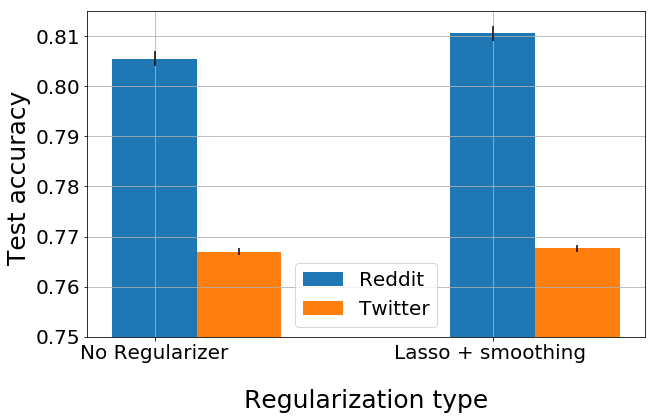

In [18]:
test_acc_r =  np.array([0.8055, 0.810515])
acc_error_r = np.array([0.0015, 0.00145])

test_acc_t =  np.array([0.7670, 0.767685])
acc_error_t = np.array([0.00072, 0.0007174])


colors = ['b']
x = np.arange(2)
xnames = ['No Regularizer', 'Lasso + smoothing \n']

#----------------Test accuracy
fig = plt.figure()
fig.set_size_inches(10, 6)
#plt.title("Model 3: controlling for user and topic")

#plt.errorbar(x, res_feu , yerr = err_feu, linestyle='-', marker='o', color='b')
fig = plt.figure()
#plt.style.use('seaborn')
plt.grid(True)
fig.set_size_inches(10, 6)
#plt.title("Model 1: controlling for user")

baseline = 0.75
plt.bar(x+0.0, test_acc_r-baseline, yerr = acc_error_r, bottom = baseline, width = 0.25, align='center', ecolor='k', label='Reddit')
plt.bar(x+0.25, test_acc_t-baseline, yerr = acc_error_t, bottom=baseline, width = 0.25, align='center', ecolor='k',label='Twitter')


plt.ylabel('Test accuracy ', fontsize = 25)
plt.xlabel('Regularization type', fontsize = 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(x, xnames)
plt.legend(loc='best', fontsize=20)
plt.savefig('smooth_effect.png', bbox_inches='tight')

### Comparision of different models with / without adding a modeling a feature:

In [19]:
res_df = pd.read_csv('feature_importance.csv')
res_df = res_df.drop([0,2,3,5,6,7])
res_df

Unnamed: 0  best param C  Feedback_Est  Feedback_stderr  \
1             model_fb_dt          0.01     -0.285294         0.012948   
4             model_event         10.00     -0.330219         0.015741   
8  model_user_topic_event          1.00      0.271801         0.018076   

   test_accuracy  test_accuracy_error  
1       0.702871             0.000039  
4       0.729815             0.000796  
8       0.824487             0.000619

No handles with labels found to put in legend.
No handles with labels found to put in legend.


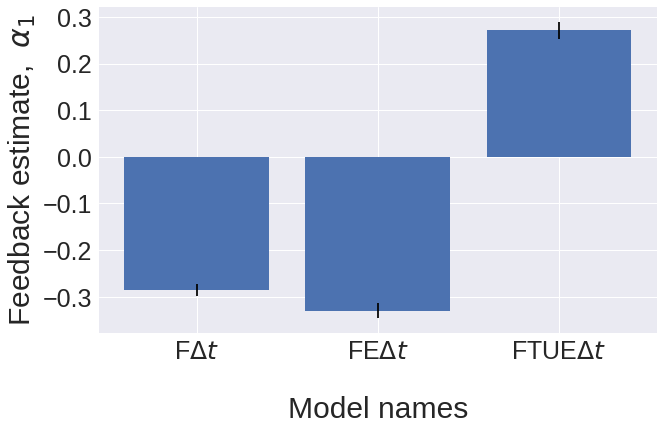

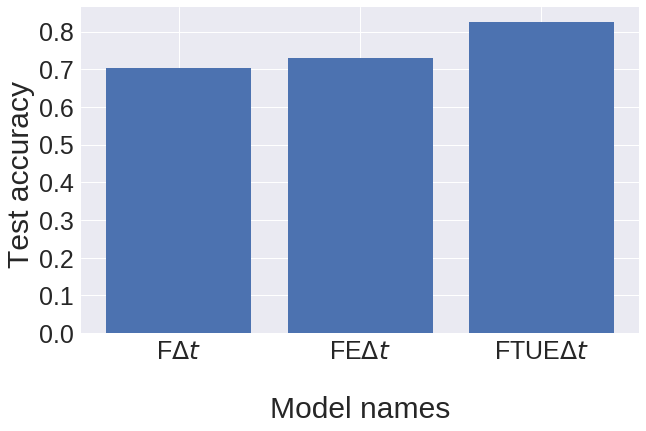

In [20]:
fb_est = res_df['Feedback_Est']
fb_est_std = res_df['Feedback_stderr']
test_accuracies = res_df['test_accuracy']
params_C = res_df['best param C']
model_indexes = list(range(3))
#model_names = ['F','F'r'$\Delta t$', 'FU'r'$\Delta t$', 'FT'r'$\Delta t$', 'FE'r'$\Delta t$',
#               'FUT'r'$\Delta t$', 'FUE'r'$\Delta t$', 'FTE'r'$\Delta t$', 'FTUE'r'$\Delta t$']

model_names = ['F'r'$\Delta t$', 'FE'r'$\Delta t$', 'FTUE'r'$\Delta t$' '\n']

# Feedback estimate
fig = plt.figure()
plt.style.use('seaborn')
fig.set_size_inches(10, 6)
#plt.title("Model 1: controlling for user")

plt.bar(model_indexes, fb_est, yerr = fb_est_std, align='center', ecolor='k')
        
plt.ylabel('Feedback estimate,  ' r'$\alpha_1$', fontsize = 30)
plt.xlabel('Model names', fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(model_indexes, model_names)
plt.legend(loc='best', fontsize=25)

plt.savefig('reddit_fb_params.png', bbox_inches='tight')

# Accuracy of models
fig = plt.figure()
plt.style.use('seaborn')
fig.set_size_inches(10, 6)
#plt.title("Model 1: controlling for user")

plt.bar(model_indexes, test_accuracies, align='center', ecolor='k')
        
plt.ylabel('Test accuracy ', fontsize = 30)
plt.xlabel('Model names', fontsize = 30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(model_indexes, model_names)
plt.legend(loc='best')
plt.savefig('reddit_model_accuracies.png', bbox_inches='tight')

### Test Accuracy for model_topic_event_user

No handles with labels found to put in legend.


[[0.82448739 0.82449579 0.82661384 0.82617394]
 [0.         0.         0.         0.        ]]
[[0.00061864 0.00062077 0.00072562 0.00941906]
 [0.         0.         0.         0.        ]]
[[0.27180068 0.27346185 0.22309413 0.21869018]
 [0.         0.         0.         0.        ]]
[[0.01807641 0.01793689 0.02596201 0.14773217]
 [0.         0.         0.         0.        ]]


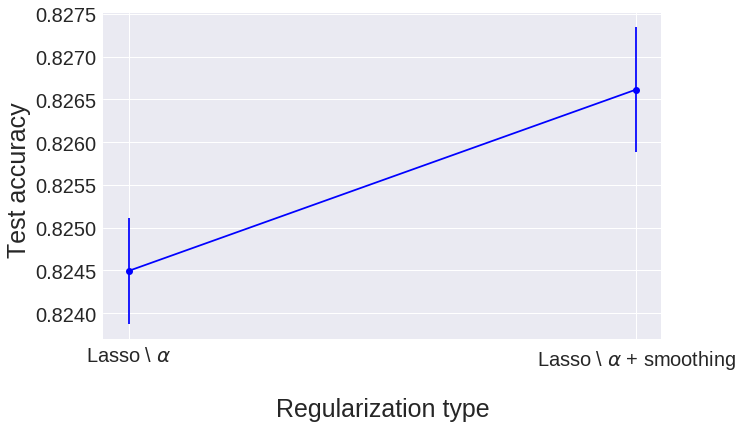

In [21]:
# Model 3 results
fb = np.zeros((2, 4))
fb_error = np.zeros((2, 4))
test_acc = np.zeros((2, 4))
test_acc_error = np.zeros((2, 4))
for b in range(1):
    res_acc = np.loadtxt('accuracy'+str(b+1)+'boot_ut.txt').reshape(4, -1)
    test_acc[b] = res_acc[:,-2]
    test_acc_error[b] = res_acc[:,-1]
    for m in range(4):
        res_base = np.loadtxt('model_parameters_'+str(b+1)+'boot_ut'+str(m)+'.txt').reshape(2, -1)
        fb[b,m] =res_base[0][0]
        fb_error[b,m] =res_base[1][0]
print(test_acc)
print(test_acc_error)
results_bin_obj = {'cv_score': np.array([[0.7678, 0.7678, 0.76842, 0.76843], [0.76829, 0.76826, 0.7691, 0.76915]]), 
                   'cv_std': np.array([[0.00097, 0.00096, 0.00121, 0.00129], [0.00093, 0.0009, 0.00107, 0.0012]]),
                   'test_score': np.array([[0.76786, 0.76785, 0.7684, 0.76837], [0.7692, 0.7691, 0.76975, 0.76977]]),
                   #'fb_param': np.array([[0.3103, 0.3079, 0.3087, 0.31164], [0.29175, 0.2898, 0.2950, 0.2983]]),
                   'test_acc': test_acc,
                   'acc_error': test_acc_error,
                   'fb_param': fb,
                   'fb_error': fb_error,
                  }

print(results_bin_obj['fb_param'])
print(results_bin_obj['fb_error'])


user_idx = 7212
bins_per_day = np.array([1])
colors = ['b']
x = range(2)
xnames = ['Lasso \ 'r'$\alpha$' , 'Lasso \ 'r'$\alpha$ + smoothing' '\n']
labelnames = ['1 bin per day']
binc=0

#----------------Test accuracy
fig = plt.figure()
fig.set_size_inches(10, 6)
#plt.title("Model 3: controlling for user and topic")
res_feutdt = results_bin_obj['test_acc'][binc]
err_feutdt = results_bin_obj['acc_error'][binc]

plt.errorbar(x, [res_feutdt[1], res_feutdt[2]] , yerr = [err_feutdt[1], err_feutdt[2]], linestyle='-', marker='o', color=colors[binc])

plt.ylabel('Test accuracy ', fontsize = 25)
plt.xlabel('Regularization type', fontsize = 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(x, xnames)
plt.legend(loc='best', fontsize=20)
plt.savefig('reddit_model_acc_feutdt.png', bbox_inches='tight')

### test accuracy for model_topic_event

No handles with labels found to put in legend.


[[0.82195258 0.82421168]
 [0.         0.        ]]
[[0.00352338 0.00133243]
 [0.         0.        ]]
[[0.38600593 0.36595521]
 [0.         0.        ]]
[[0.07019009 0.03383908]
 [0.         0.        ]]


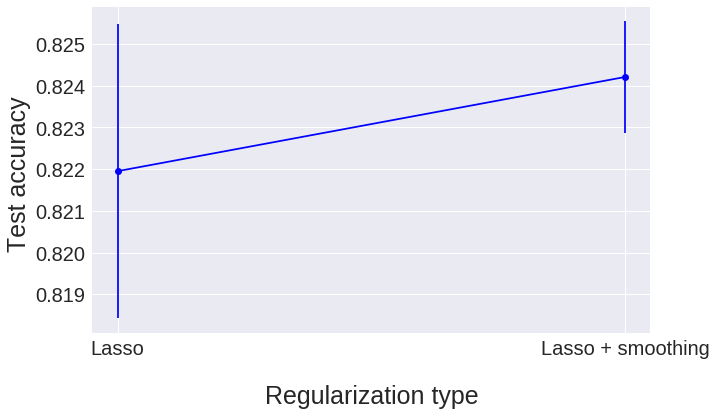

In [22]:
# Model 3 results
fb = np.zeros((2, 2))
fb_error = np.zeros((2, 2))
test_acc = np.zeros((2, 2))
test_acc_error = np.zeros((2, 2))
for b in range(1):
    res_acc = np.loadtxt('accuracy'+str(b+1)+'boot_eu_n.txt').reshape(2, -1)
    test_acc[b] = res_acc[:,-2]
    test_acc_error[b] = res_acc[:,-1]
    h=0
    for m in range(2,4):
        res_base = np.loadtxt('model_parameters_'+str(b+1)+'boot_eu_n'+str(m)+'.txt').reshape(2, -1)
        fb[b,h] =res_base[0][0]
        fb_error[b,h] =res_base[1][0]
        h+=1
print(test_acc)
print(test_acc_error)
results_bin_obj = {'cv_score': np.array([[0.7678, 0.7678, 0.76842, 0.76843], [0.76829, 0.76826, 0.7691, 0.76915]]), 
                   'cv_std': np.array([[0.00097, 0.00096, 0.00121, 0.00129], [0.00093, 0.0009, 0.00107, 0.0012]]),
                   'test_score': np.array([[0.76786, 0.76785, 0.7684, 0.76837], [0.7692, 0.7691, 0.76975, 0.76977]]),
                   #'fb_param': np.array([[0.3103, 0.3079, 0.3087, 0.31164], [0.29175, 0.2898, 0.2950, 0.2983]]),
                   'test_acc': test_acc,
                   'acc_error': test_acc_error,
                   'fb_param': fb,
                   'fb_error': fb_error,
                  }

user_idx = 7212
bins_per_day = np.array([1])
colors = ['b']
x = range(2)
xnames = ['Lasso' , 'Lasso + smoothing' '\n']
labelnames = ['1 bin per day']
binc=0
print(results_bin_obj['fb_param'])
print(results_bin_obj['fb_error'])

#----------------Test accuracy
fig = plt.figure()
fig.set_size_inches(10, 6)
#plt.title("Model 3: controlling for user and topic")
res_feutdt = results_bin_obj['test_acc'][binc]
err_feutdt = results_bin_obj['acc_error'][binc]

plt.errorbar(x, [res_feutdt[0], res_feutdt[1]] , yerr = [err_feutdt[0], err_feutdt[1]], linestyle='-', marker='o', color=colors[binc])

plt.ylabel('Test accuracy ', fontsize = 25)
plt.xlabel('Regularization type', fontsize = 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(x, xnames)
plt.legend(loc='best', fontsize=20)
plt.savefig('reddit_model_acc_feudt.png', bbox_inches='tight')

### test accuracy for model_event

No handles with labels found to put in legend.


[[-0.1311353   0.16558864  0.25355015  0.45424906]
 [ 0.          0.          0.          0.        ]]
[[0.02997006 0.15881735 0.02248067 0.61677926]
 [0.         0.         0.         0.        ]]


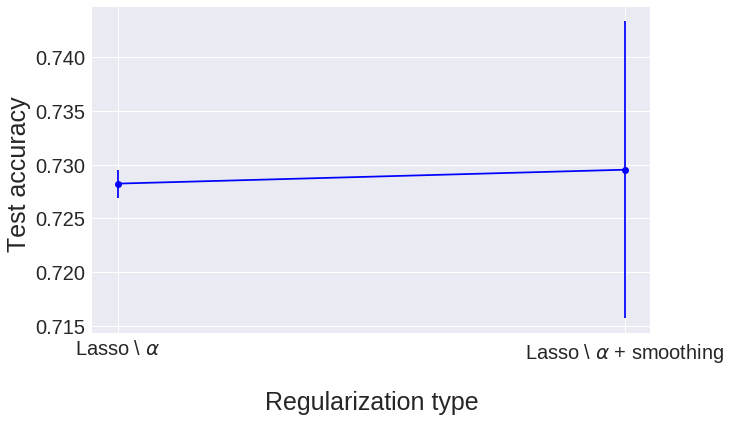

In [23]:
# Model 3 results
fb = np.zeros((2, 4))
fb_error = np.zeros((2, 4))
test_acc = np.zeros((2, 4))
test_acc_error = np.zeros((2, 4))
for b in range(1):
    res_acc = np.loadtxt('accuracy'+str(b+1)+'boot_e.txt').reshape(4, -1)
    test_acc[b] = res_acc[:,-2]
    test_acc_error[b] = res_acc[:,-1]
    for m in range(4):
        res_base = np.loadtxt('model_parameters_'+str(b+1)+'boot_e'+str(m)+'.txt').reshape(2, -1)
        fb[b,m] =res_base[0][0]
        fb_error[b,m] =res_base[1][0]

results_bin_obj = {
                   'test_acc': test_acc,
                   'acc_error': test_acc_error,
                   'fb_param': fb,
                   'fb_error': fb_error,
                  }

print(results_bin_obj['fb_param'])
print(results_bin_obj['fb_error'])
user_idx = 7212
bins_per_day = np.array([1])
colors = ['b']
x = range(2)
xnames = ['Lasso \ 'r'$\alpha$' , 'Lasso \ 'r'$\alpha$ + smoothing' '\n']
labelnames = ['1 bin per day', '2 bins per day']
binc=0

#----------------Test accuracy
fig = plt.figure()
fig.set_size_inches(10, 6)
#plt.title("Model 3: controlling for user and topic")
res_feutdt = results_bin_obj['test_acc'][binc]
err_feutdt = results_bin_obj['acc_error'][binc]
#plt.errorbar(x, res_feutdt , yerr = err_feutdt, linestyle='-', marker='o', color='b')
plt.errorbar(x, [res_feutdt[1], res_feutdt[2]] , yerr = [err_feutdt[1], err_feutdt[2]], linestyle='-', marker='o', color=colors[binc])


plt.ylabel('Test accuracy ', fontsize = 25)
plt.xlabel('Regularization type', fontsize = 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(x, xnames)
plt.legend(loc='best', fontsize=20)
plt.savefig('reddit_model_acc_fedt.png', bbox_inches='tight')

### Match Topic index to Topic name

In [24]:
with open('top_100_subreddits.csv', 'r') as f:
    subred_lines = f.readlines()

dict_id_subreddit = {}
for line in subred_lines:
    if not line.startswith('subreddit_id'):
        subred_data = line.strip().split(',')
        sub_id = subred_data[0]
        sub_name = subred_data[1]
        dict_id_subreddit[sub_id] = sub_name
        
with open('columnnames.txt', 'r') as f:
    col_lines = f.readlines()

dict_topicId_subId = {}
k=0
for line in col_lines:
    if line.strip().startswith('topic'):
        sub_id = line[6:].strip()
        dict_topicId_subId[k] = sub_id
        k+=1
    
    

### $\beta$ parameters for Topic 98

No handles with labels found to put in legend.
No handles with labels found to put in legend.


# topics with 3 consecutive positive betas  1


No handles with labels found to put in legend.


# topics with 3 consecutive positive betas  1


No handles with labels found to put in legend.


# topics with 3 consecutive positive betas  1
# topics with 3 consecutive positive betas  1


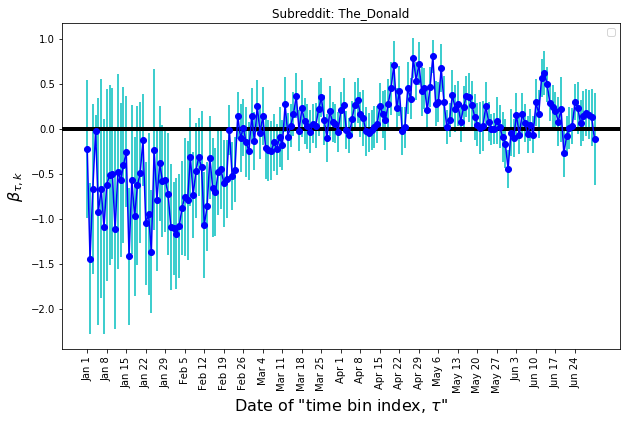

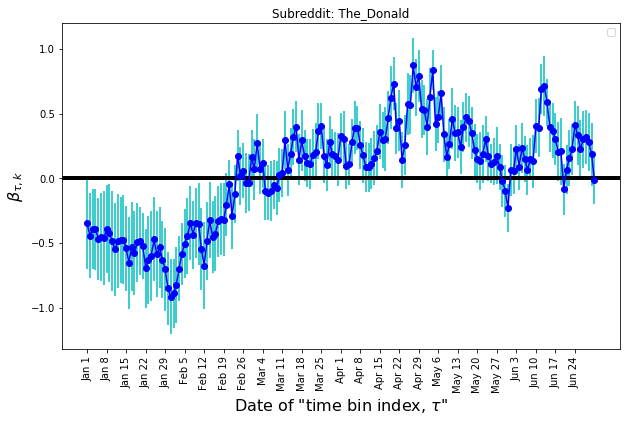

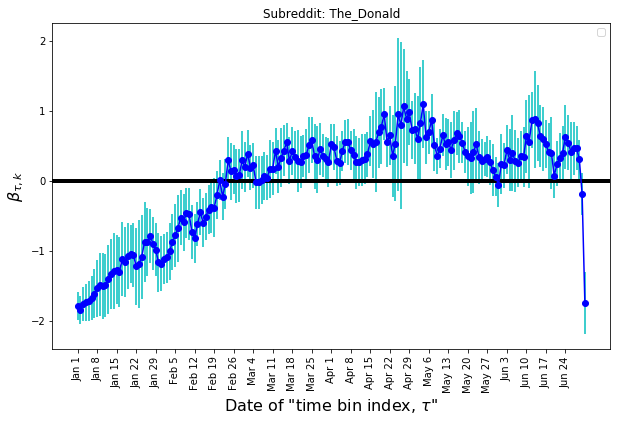

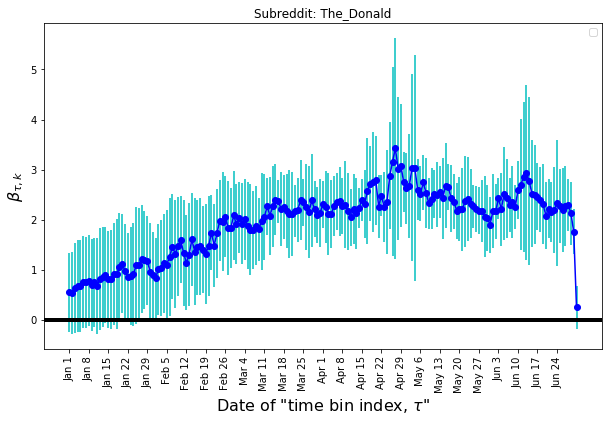

In [28]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)

def process_data(suffix_name, start_idx, dict_id_subreddit, dict_topicId_subId, prefix_name='feutdt'):
    j=0
    
    data = np.loadtxt('model_parameters_'+str(1)+suffix_name)

    res = data[0]
    res_error = data[1]
    binc=1
    #print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    #print(N)

    no_topics = 100
    topic_time_evt_matrix = res[start_idx:].flatten().reshape(no_topics, -1)
    topic_time_evt_matrix_std = res_error[start_idx:].flatten().reshape(no_topics, -1)
    
    if prefix_name == 'feudt':
        topic_time_evt_matrix = preprocessing.scale(topic_time_evt_matrix, axis=1, with_std=False)


    jan = ['Jan '+str(i+1) for i in range(31)]
    feb = ['Feb '+str(i+1) for i in range(29)]
    mar = ['Mar '+str(i+1) for i in range(31)]
    apr = ['Apr '+str(i+1) for i in range(30)]
    may = ['May '+str(i+1) for i in range(31)]
    jun = ['Jun '+str(i+1) for i in range(30)]

    time_bins = np.array(jan+feb+mar+apr+may+jun)
    x_bins = [k for k in range(182) if k%7==0]

    imp_topics = [98]  # selected by comparing beta value with topic definition
    topic_NoconsEvents = {}
    no_topics_with_consEvts = 0
    for top in imp_topics:

        res = topic_time_evt_matrix[top]
        N = len(res)
        error = topic_time_evt_matrix_std[top]

        res_min_error = res - error
        res_min_error[res_min_error<0] = 0

        result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
        topic_NoconsEvents[top] = len(result)


        if len(result) > 0:
            no_topics_with_consEvts+=1
            #print(top, np.array(result_idx)+1)
            j+=1
            title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)



        autocorr = pearsonr(res[:-1], res[1:])[0]
        #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
        fig = plt.figure()
        fig.subplots_adjust(hspace=.50)
        fig.set_size_inches(10, 6)
        plt.subplot(1, 1, 1)
        plt.title('Subreddit: '+dict_id_subreddit[dict_topicId_subId[top]])
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)

        plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
        plt.axhline(linewidth=4, color='k')
        plt.xticks(x_bins, time_bins[x_bins])
        plt.xticks(rotation=90)
        plt.locator_params(axis='x', nbins=27)
        plt.legend(loc='best')
        plt.savefig('reddit_'+prefix_name+'_beta_topic'+str(top)+'.png', bbox_inches='tight')

    print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)


    
suffix_name = 'boot_ut0.txt'
start_idx = 100+11813+2
process_data(suffix_name, start_idx, dict_id_subreddit, dict_topicId_subId, prefix_name='feutdt_lasso')

suffix_name = 'boot_ut2.txt'
start_idx = 100+11813+2
process_data(suffix_name, start_idx, dict_id_subreddit, dict_topicId_subId, prefix_name='feutdt')

suffix_name = 'boot_eu2.txt'
start_idx = 11813+2
process_data(suffix_name, start_idx, dict_id_subreddit, dict_topicId_subId, prefix_name='feudt')
suffix_name = 'boot_e2.txt'
start_idx = 2
process_data(suffix_name, start_idx, dict_id_subreddit, dict_topicId_subId, prefix_name='fedt')

## Model 1: controlling for user
\begin{equation}
y_i = \sigma \left(\alpha_1 T_i + \alpha_2 \Delta t_i + \sum_{\tau=0}^{B}  \sum_{k=0}^{100} \delta_{\tau_i \tau} \delta_{k_i k}  \beta_{\tau k} + \sum_{u=0} \gamma_u \delta_{u u_i} \right)
\label{eq:model_logit}
\end{equation}

In [30]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)


#no_users = 11813
#user_idx = no_users + 2
user_idx = 10807 + 1
j=0

#data = np.loadtxt('model_parameters_'+str(1)+'boot_eu_n3.txt')
data = np.loadtxt('model_parameters_model_user_event_fb_ndt.txt')
res = data[0]
res_error = data[1]
binc=1
print('Non-zero features: ', len(np.where(res!=0)[0]))
N = len(res)
print(N)

no_topics = 100
topic_time_evt_matrix = res[user_idx:].flatten().reshape(no_topics, -1)
topic_time_evt_matrix_std = res_error[user_idx:].flatten().reshape(no_topics, -1)

topic_time_evt_matrix = preprocessing.scale(topic_time_evt_matrix, axis=1, with_std=False)


jan = ['Jan '+str(i+1) for i in range(31)]
feb = ['Feb '+str(i+1) for i in range(29)]
mar = ['Mar '+str(i+1) for i in range(31)]
apr = ['Apr '+str(i+1) for i in range(30)]
may = ['May '+str(i+1) for i in range(31)]
jun = ['Jun '+str(i+1) for i in range(30)]

time_bins = np.array(jan+feb+mar+apr+may+jun)
x_bins = [k for k in range(182) if k%7==0]

imp_topics = range(100)  # selected by comparing beta value with topic definition
topic_NoconsEvents = {}
no_topics_with_consEvts = 0
identified_subreddits = []
for top in imp_topics:
    
    res = topic_time_evt_matrix[top]
    N = len(res)
    error = topic_time_evt_matrix_std[top]

    res_min_error = res - error
    res_min_error[res_min_error<0] = 0
    
    result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
    topic_NoconsEvents[top] = len(result)
    
    
    if len(result) > 0:
        no_topics_with_consEvts+=1
        print(top, np.array(result_idx)+1)
        j+=1
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)
    else:
        continue
    

    autocorr = pearsonr(res[:-1], res[1:])[0]
    #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

    minr = np.min(res)
    maxr = np.max(res)
    fig = plt.figure()
    fig.subplots_adjust(hspace=.50)
    fig.set_size_inches(10, 6)
    plt.subplot(1, 1, 1)
    identified_subreddits.append(dict_id_subreddit[dict_topicId_subId[top]])
    plt.title('Subreddit: '+dict_id_subreddit[dict_topicId_subId[top]])
    plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
    plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)

    plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
    #plt.stem(list(range(N)), [0]*N, linestyle='-', marker='o', color='r')
    plt.axhline(linewidth=4, color='k')
    #plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
    #plt.plot([2,2], [minr-2, maxr+2], color='k')
    #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.xticks(x_bins, time_bins[x_bins])
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=27)
    plt.legend(loc='best')
    plt.savefig('reddit_fuedt_beta_topic'+str(top)+'.png', bbox_inches='tight')


print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)
for sub in identified_subreddits:
    print(sub)                                            
#print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
#print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])

Non-zero features:  52583
53739


ValueError: cannot reshape array of size 30113 into shape (100,newaxis)

## Model 2: controlling for topic
\begin{equation}
y_i = \sigma \left(\alpha_1 T_i + \alpha_2 \Delta t_i + \sum_{\tau=0}^{B}  \sum_{k=0}^{100} \delta_{\tau_i \tau} \delta_{k_i k}  \beta_{\tau k} + \sum_{k=0} \phi_k \delta_{k k_i} \right)
\label{eq:model_logit}
\end{equation}

## Model 3: controlling for user and topic
\begin{equation}
y_i = \sigma \left(\alpha_1 T_i + \alpha_2 \Delta t_i + \sum_{\tau=0}^{B}  \sum_{k=0}^{100} \delta_{\tau_i \tau} \delta_{k_i k}  \beta_{\tau k} + \sum_{u=0} \gamma_u \delta_{u u_i} + \sum_{k=0} \phi_k \delta_{k k_i} \right)
\label{eq:model_logit}
\end{equation}

Non-zero features:  29608
30215
(100, 183)
0 [[43 44 45]
 [44 45 46]
 [57 58 59]
 [62 63 64]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


1 [[130 131 132]
 [131 132 133]
 [132 133 134]
 [133 134 135]
 [134 135 136]
 [164 165 166]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


3 [[17 18 19]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


5 [[155 156 157]
 [156 157 158]
 [165 166 167]
 [173 174 175]
 [174 175 176]
 [175 176 177]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


11 [[146 147 148]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


14 [[28 29 30]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


15 [[22 23 24]
 [23 24 25]
 [24 25 26]
 [25 26 27]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


18 [[83 84 85]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


20 [[134 135 136]
 [135 136 137]
 [136 137 138]
 [137 138 139]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


21 [[ 51  52  53]
 [175 176 177]
 [176 177 178]
 [177 178 179]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


24 [[176 177 178]
 [177 178 179]
 [178 179 180]
 [179 180 181]
 [180 181 182]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


25 [[163 164 165]
 [164 165 166]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


27 [[23 24 25]
 [24 25 26]
 [25 26 27]
 [26 27 28]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


28 [[29 30 31]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


30 [[56 57 58]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


38 [[32 33 34]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


39 [[ 56  57  58]
 [ 57  58  59]
 [130 131 132]
 [131 132 133]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


40 [[ 3  4  5]
 [ 4  5  6]
 [ 5  6  7]
 [ 6  7  8]
 [ 7  8  9]
 [ 8  9 10]
 [ 9 10 11]
 [59 60 61]
 [60 61 62]
 [61 62 63]
 [66 67 68]
 [67 68 69]
 [68 69 70]
 [80 81 82]
 [81 82 83]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


44 [[ 48  49  50]
 [174 175 176]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


51 [[147 148 149]
 [148 149 150]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


55 [[13 14 15]
 [14 15 16]
 [15 16 17]
 [19 20 21]
 [20 21 22]
 [26 27 28]
 [35 36 37]
 [36 37 38]
 [37 38 39]
 [96 97 98]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


58 [[69 70 71]
 [70 71 72]
 [77 78 79]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


59 [[177 178 179]
 [178 179 180]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


72 [[92 93 94]
 [93 94 95]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


74 [[48 49 50]
 [49 50 51]
 [90 91 92]
 [91 92 93]
 [92 93 94]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


75 [[ 9 10 11]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


80 [[87 88 89]
 [88 89 90]
 [89 90 91]
 [90 91 92]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


82 [[126 127 128]
 [127 128 129]
 [128 129 130]
 [144 145 146]
 [145 146 147]
 [146 147 148]
 [147 148 149]
 [148 149 150]
 [149 150 151]
 [150 151 152]
 [151 152 153]
 [152 153 154]
 [153 154 155]
 [154 155 156]
 [155 156 157]
 [156 157 158]
 [157 158 159]
 [158 159 160]
 [180 181 182]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


86 [[114 115 116]
 [115 116 117]
 [116 117 118]
 [117 118 119]
 [118 119 120]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


87 [[ 82  83  84]
 [101 102 103]
 [102 103 104]
 [103 104 105]
 [104 105 106]
 [105 106 107]
 [106 107 108]
 [107 108 109]
 [108 109 110]
 [109 110 111]
 [110 111 112]
 [111 112 113]
 [112 113 114]
 [113 114 115]
 [114 115 116]
 [115 116 117]
 [116 117 118]
 [117 118 119]
 [118 119 120]
 [119 120 121]
 [120 121 122]
 [121 122 123]
 [122 123 124]
 [123 124 125]
 [124 125 126]
 [125 126 127]
 [126 127 128]
 [127 128 129]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


90 [[ 68  69  70]
 [ 69  70  71]
 [ 70  71  72]
 [ 71  72  73]
 [ 72  73  74]
 [ 73  74  75]
 [ 74  75  76]
 [ 75  76  77]
 [ 76  77  78]
 [ 77  78  79]
 [ 78  79  80]
 [ 79  80  81]
 [ 80  81  82]
 [ 81  82  83]
 [ 82  83  84]
 [ 83  84  85]
 [ 84  85  86]
 [ 93  94  95]
 [ 94  95  96]
 [102 103 104]
 [106 107 108]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


91 [[79 80 81]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


92 [[17 18 19]
 [18 19 20]
 [19 20 21]
 [20 21 22]
 [21 22 23]
 [31 32 33]
 [32 33 34]
 [33 34 35]
 [34 35 36]
 [35 36 37]
 [41 42 43]
 [42 43 44]
 [43 44 45]
 [44 45 46]
 [49 50 51]
 [50 51 52]
 [51 52 53]
 [52 53 54]
 [53 54 55]
 [54 55 56]
 [59 60 61]
 [60 61 62]
 [61 62 63]
 [65 66 67]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


95 [[127 128 129]
 [128 129 130]
 [129 130 131]
 [130 131 132]
 [131 132 133]
 [132 133 134]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


96 [[ 37  38  39]
 [ 38  39  40]
 [118 119 120]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


98 [[ 96  97  98]
 [ 97  98  99]
 [105 106 107]
 [106 107 108]
 [107 108 109]
 [108 109 110]
 [109 110 111]
 [110 111 112]
 [111 112 113]
 [115 116 117]
 [116 117 118]
 [117 118 119]
 [118 119 120]
 [119 120 121]
 [120 121 122]
 [121 122 123]
 [122 123 124]
 [123 124 125]
 [124 125 126]
 [125 126 127]
 [126 127 128]
 [127 128 129]
 [131 132 133]
 [132 133 134]
 [133 134 135]
 [134 135 136]
 [135 136 137]
 [136 137 138]
 [137 138 139]
 [138 139 140]
 [162 163 164]
 [163 164 165]
 [164 165 166]
 [165 166 167]
 [166 167 168]
 [167 168 169]
 [175 176 177]
 [176 177 178]
 [177 178 179]
 [178 179 180]
 [179 180 181]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


politics
gaming
worldnews
videos
atheism
movies
europe
Christianity
australia
ukpolitics
unitedkingdom
Games
StarWars
soccer
hockey
CFB
pokemon
nfl
nba
asoiaf
leagueoflegends
CollegeBasketball
gameofthrones
SquaredCircle
GlobalOffensive
Showerthoughts
tifu
Overwatch
hearthstone
darksouls3
thedivision
heroesofthestorm
SandersForPresident
BlackPeopleTwitter
CringeAnarchy
The_Donald
# topics with 3 consecutive positive betas  36


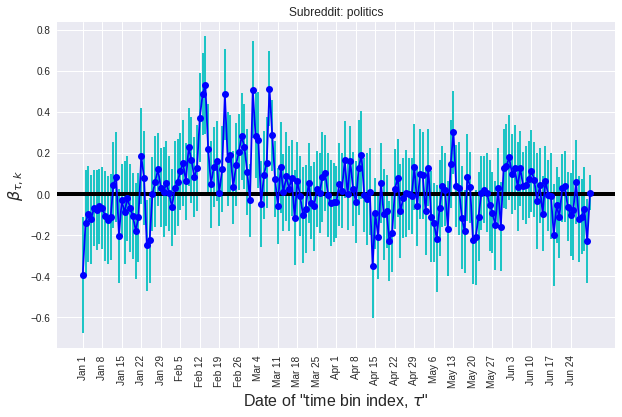

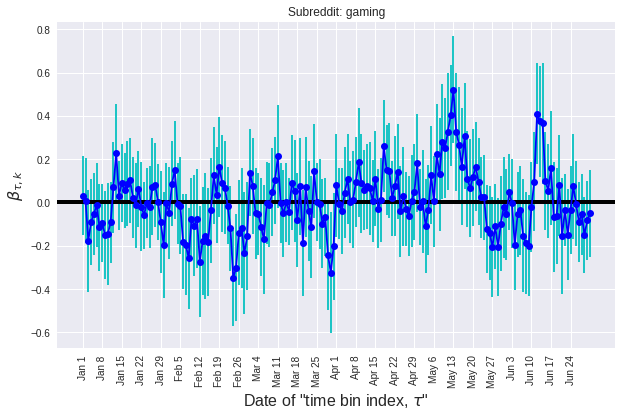

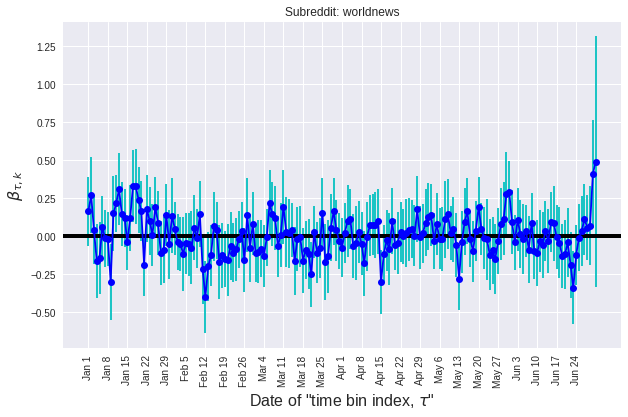

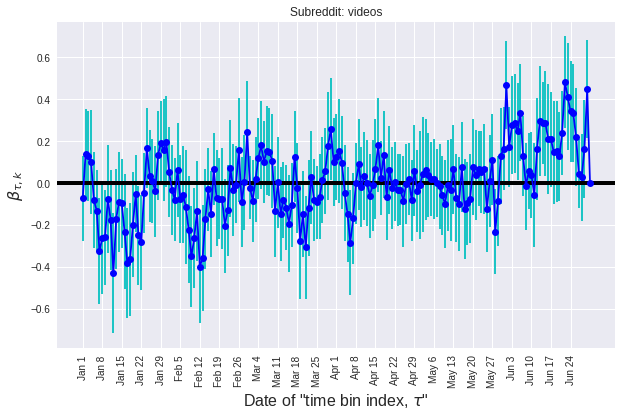

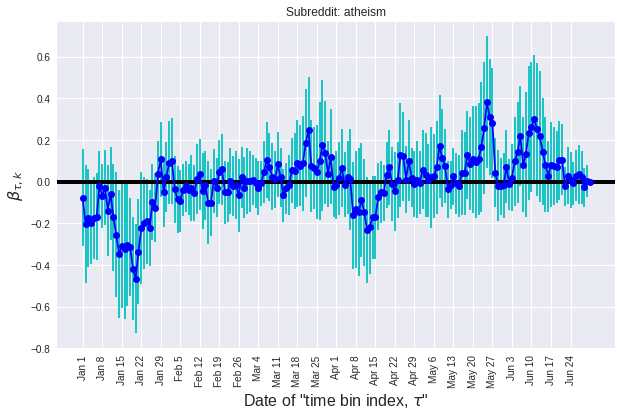

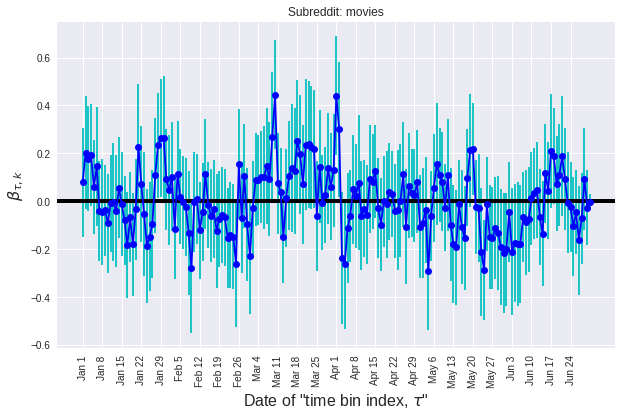

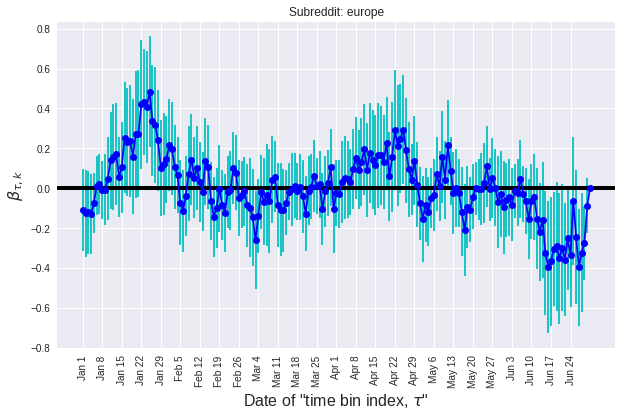

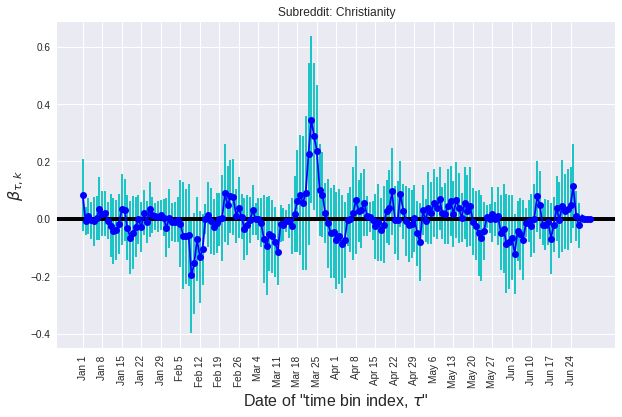

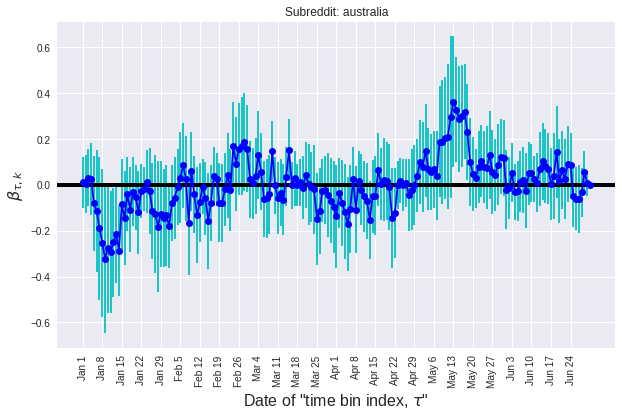

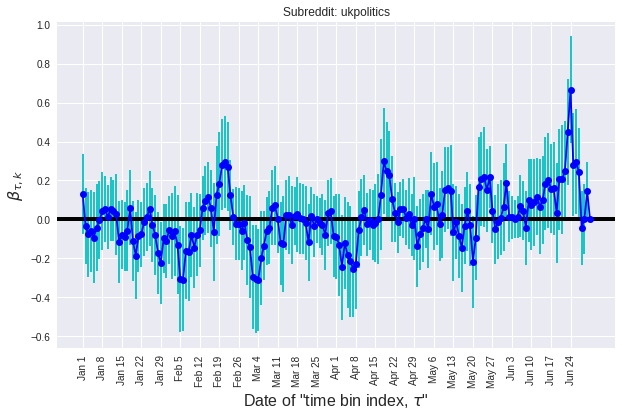

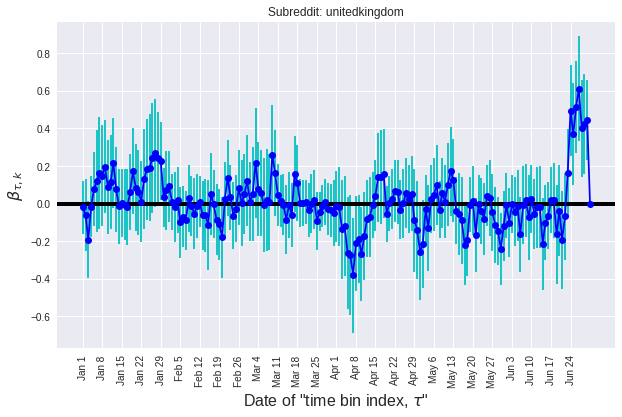

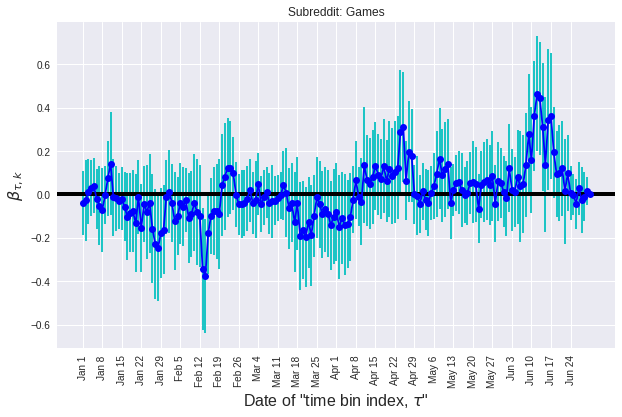

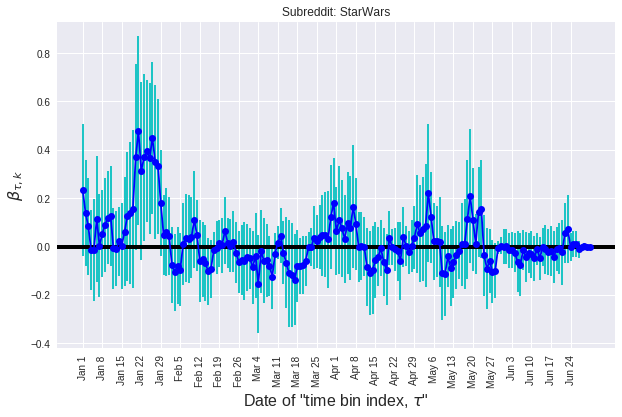

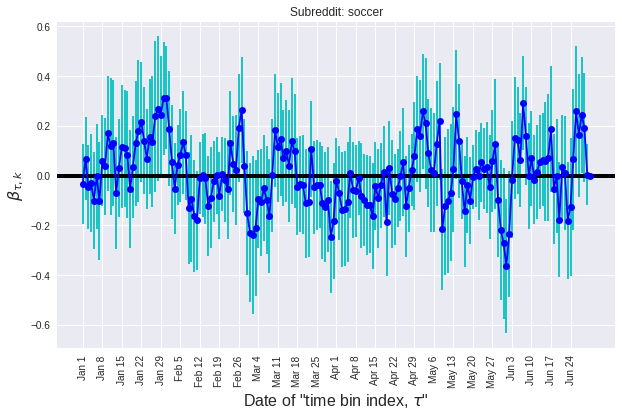

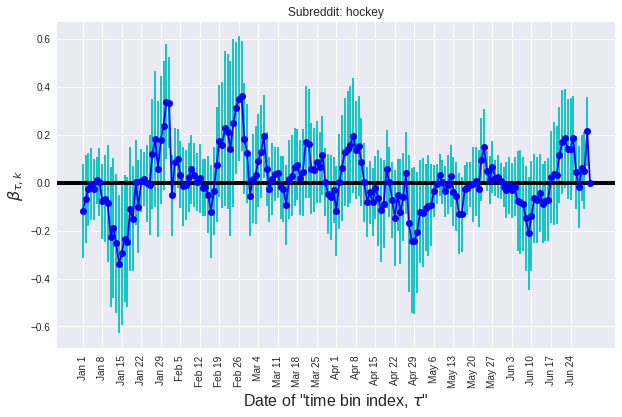

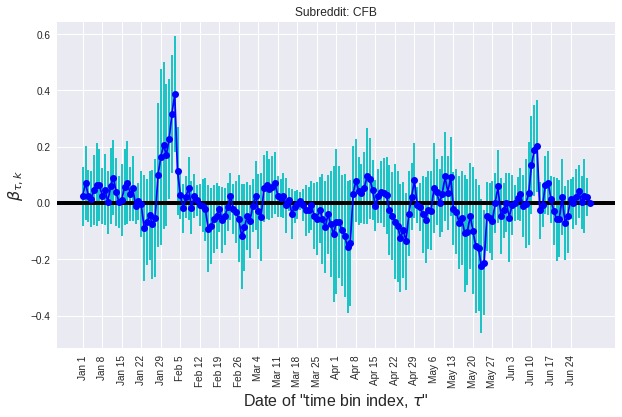

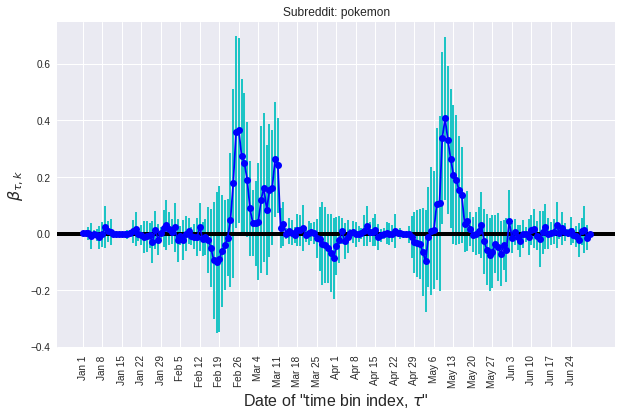

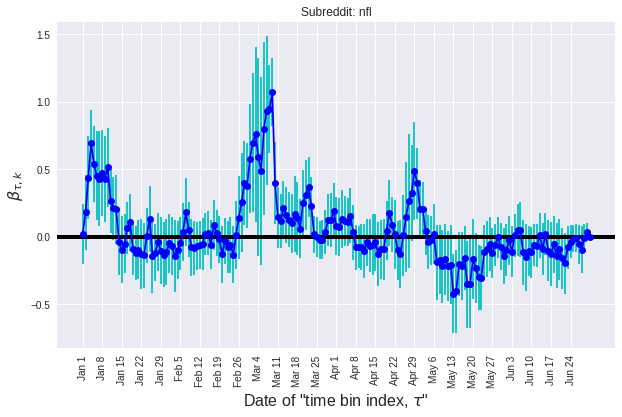

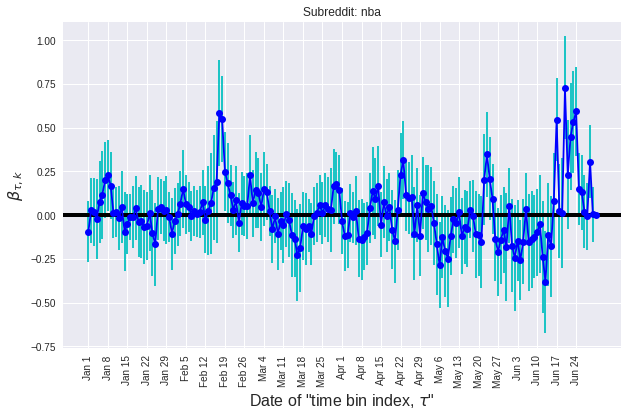

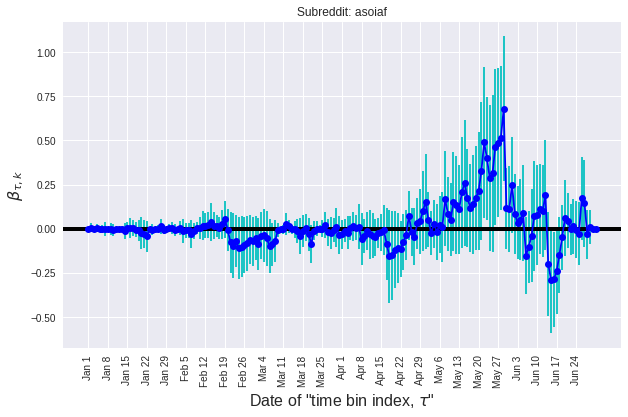

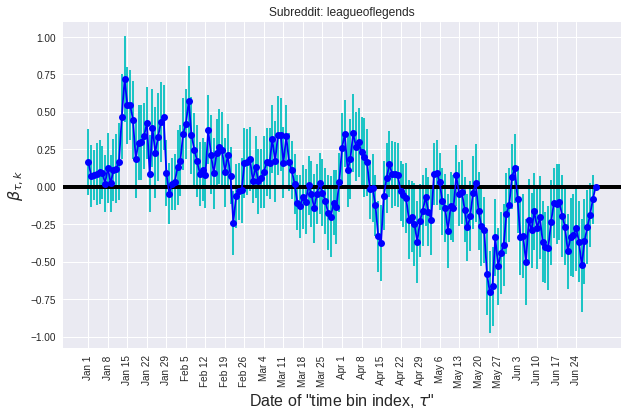

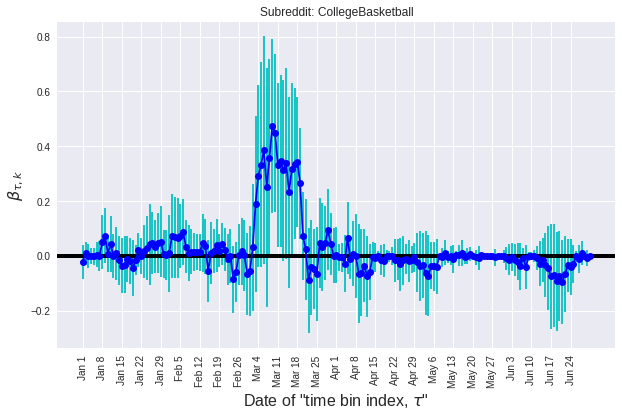

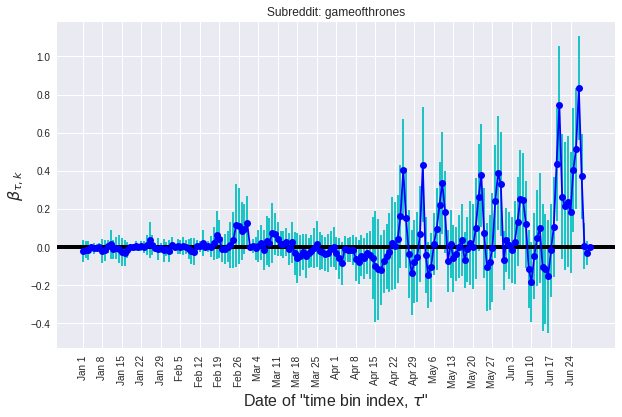

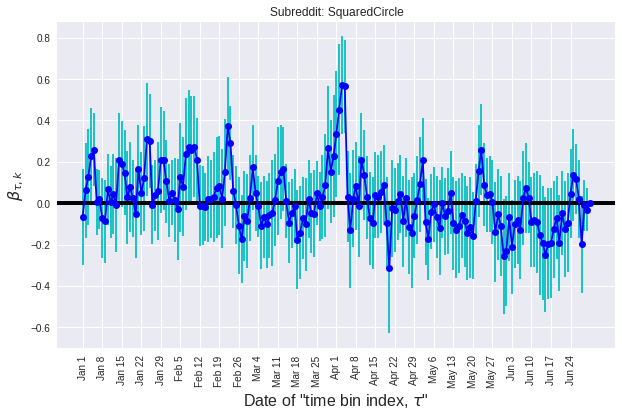

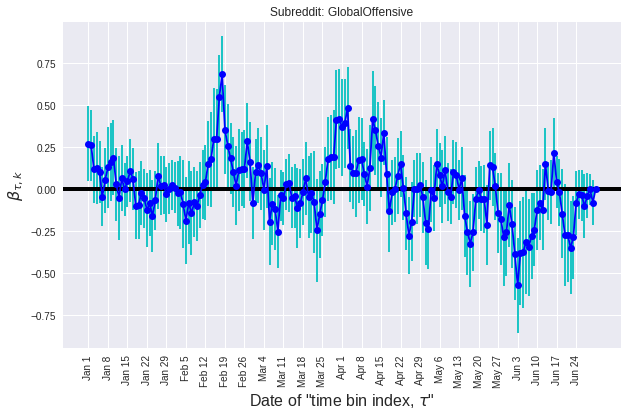

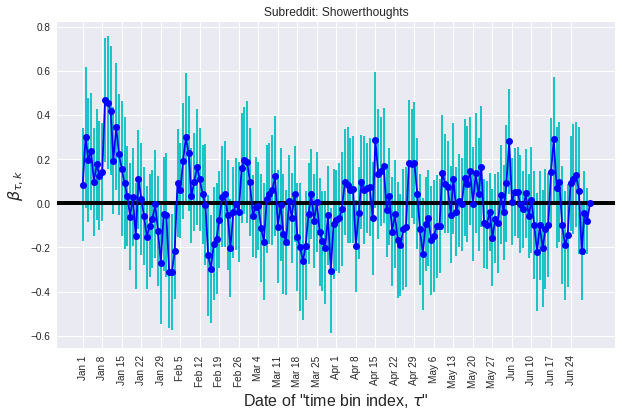

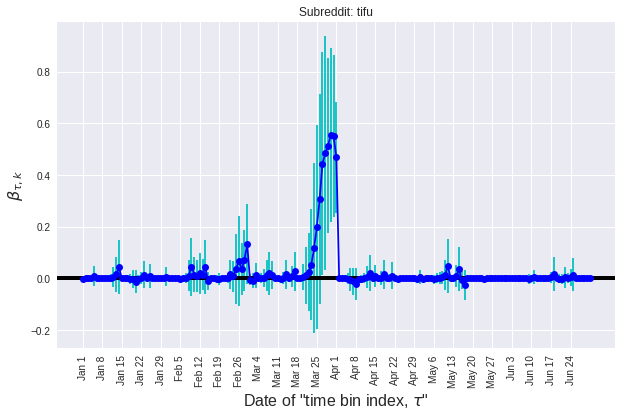

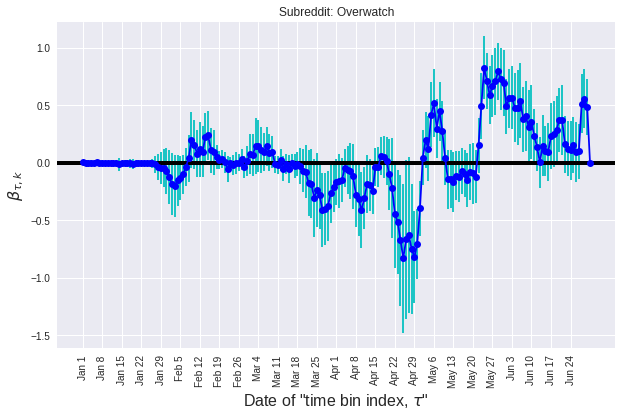

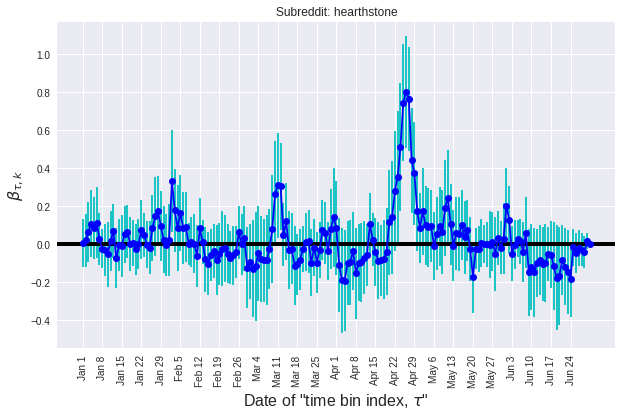

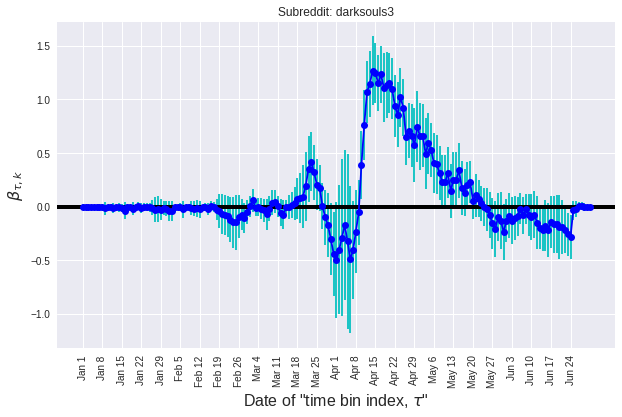

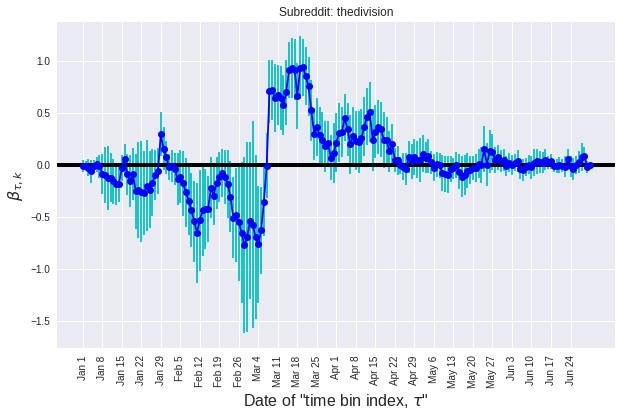

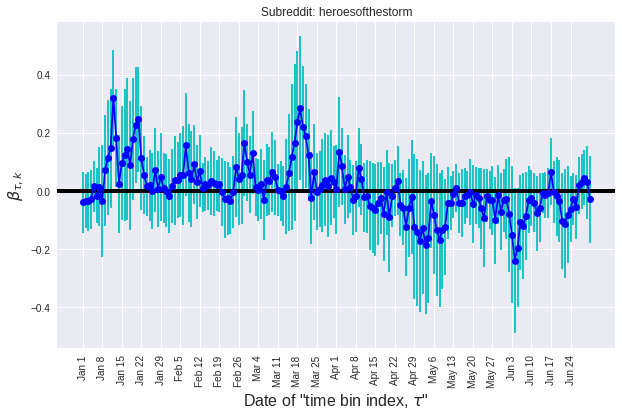

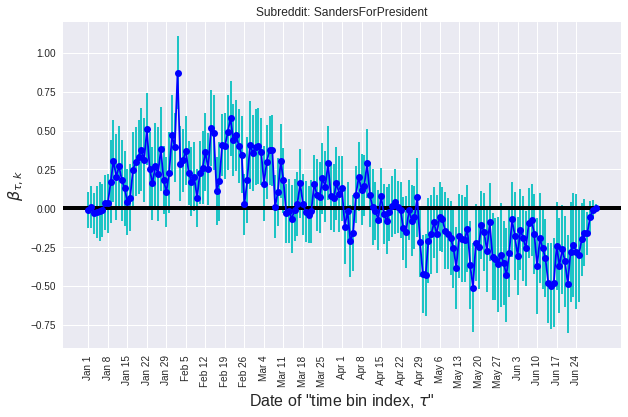

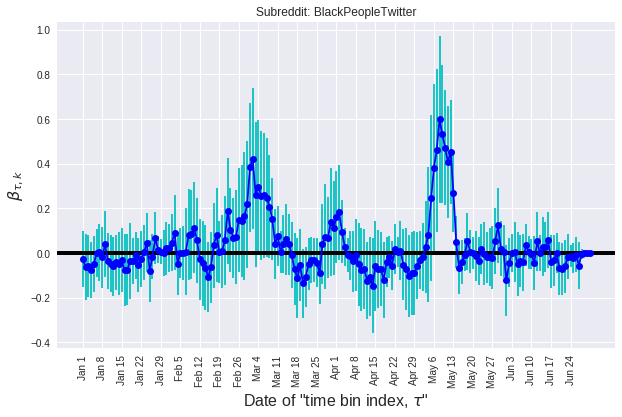

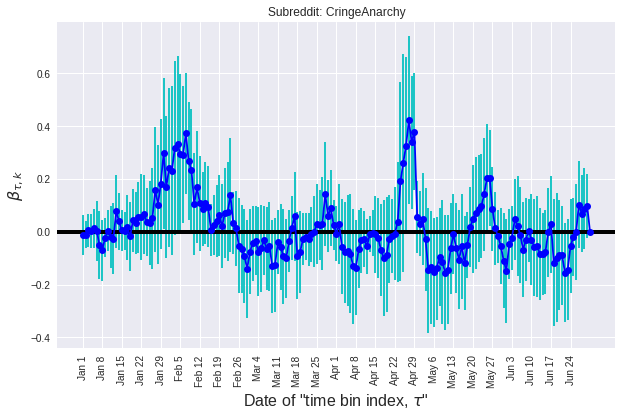

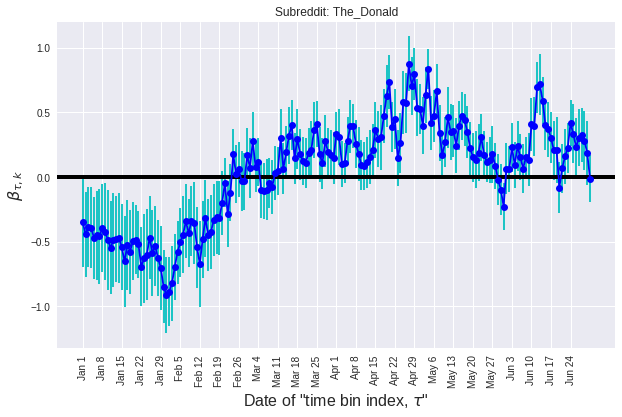

In [16]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)


no_users = 11813
user_idx = no_users + 2
j=0

data = np.loadtxt('model_parameters_'+str(1)+'boot_ut2.txt')
res = data[0]
res_error = data[1]
binc=1
print('Non-zero features: ', len(np.where(res!=0)[0]))
N = len(res)
print(N)

no_topics = 100
topic_time_evt_matrix = res[no_topics+user_idx:].flatten().reshape(no_topics, -1)
topic_time_evt_matrix_std = res_error[no_topics+user_idx:].flatten().reshape(no_topics, -1)
print(topic_time_evt_matrix.shape)

jan = ['Jan '+str(i+1) for i in range(31)]
feb = ['Feb '+str(i+1) for i in range(29)]
mar = ['Mar '+str(i+1) for i in range(31)]
apr = ['Apr '+str(i+1) for i in range(30)]
may = ['May '+str(i+1) for i in range(31)]
jun = ['Jun '+str(i+1) for i in range(30)]

time_bins = np.array(jan+feb+mar+apr+may+jun)
x_bins = [k for k in range(182) if k%7==0]

imp_topics = range(100)  # selected by comparing beta value with topic definition
topic_NoconsEvents = {}
no_topics_with_consEvts = 0
identified_subreddits=[]
for top in imp_topics:
    
    res = topic_time_evt_matrix[top]
    N = len(res)
    error = topic_time_evt_matrix_std[top]

    res_min_error = res - error
    res_min_error[res_min_error<0] = 0
    
    result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
    topic_NoconsEvents[top] = len(result)
    
    
    if len(result) > 0:
        no_topics_with_consEvts+=1
        print(top, np.array(result_idx)+1)
        j+=1
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)
    else:
        continue
    

    autocorr = pearsonr(res[:-1], res[1:])[0]
    #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

    minr = np.min(res)
    maxr = np.max(res)
    fig = plt.figure()
    fig.subplots_adjust(hspace=.50)
    fig.set_size_inches(10, 6)
    plt.subplot(1, 1, 1)
    identified_subreddits.append(dict_id_subreddit[dict_topicId_subId[top]])
    plt.title('Subreddit: '+dict_id_subreddit[dict_topicId_subId[top]])
    plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
    plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)

    plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
    #plt.stem(list(range(N)), [0]*N, linestyle='-', marker='o', color='r')
    plt.axhline(linewidth=4, color='k')
    #plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
    #plt.plot([2,2], [minr-2, maxr+2], color='k')
    #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.xticks(x_bins, time_bins[x_bins])
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=27)
    plt.legend(loc='best')
    plt.savefig('reddit_feutdt_beta_topic'+str(top)+'.png', bbox_inches='tight')


for sub in identified_subreddits:
    print(sub) 
print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)
#print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
#print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])

In [31]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)


no_user = 10948
user_idx = no_user + 1
j=0

data = np.loadtxt('model_parameters_model_user_event_perUserFb.txt')
res = data[0]
print(res.shape)
res_error = data[1]
binc=1
print('Non-zero features: ', len(np.where(res!=0)[0]))
N = len(res)
print(N)


alphas_u = res[0:no_user]
alphas_u_err = res_error[0:no_user]

np.savetxt('userTreatment_error.txt', alphas_u_err)
alphas_u_plus_error = alphas_u - alphas_u_err

nonZero = np.where(alphas_u_plus_error > 0)[0]

print('# users with non Zero (significant) effect size ', len(nonZero))
print('average alpha ', np.mean(alphas_u[nonZero]))

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Distribution of the impact of Feedback for different users")

#plt.errorbar(range(7210), alphas_u, yerr = alphas_u_err, linestyle='-', marker='o', color='b',  ecolor='c')
plt.hist(alphas_u_plus_error, align='mid', cumulative=False, weights=np.ones(len(alphas_u_plus_error)) / len(alphas_u_plus_error))     
plt.ylabel('PDF', fontsize = 16)
plt.xlabel('Impact of feedback on user u ' r'$\alpha_u$', fontsize = 16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('reddit_feedback_different_users.png', bbox_inches='tight')

'''
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Difference between test accuracy and \n test accuracy obtained by setting ' r'$\alpha_u$' ' in a percentile bin to zero')

plt.errorbar(np.arange(10,110,10), np.loadtxt('difference_in_acc.txt'), linestyle='-', marker='o', color='b', ecolor='c')
plt.ylabel('Difference in accuracy ', fontsize = 16)
plt.xlabel(r'$\alpha_u$' ' percentile', fontsize = 16)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('diff_in_accuracy.png', bbox_inches='tight')
'''
no_topics = 100
topic_time_evt_matrix = res[no_user+no_user:].flatten().reshape(no_topics, -1)
topic_time_evt_matrix_std = res_error[no_user+no_user:].flatten().reshape(no_topics, -1)
topic_time_evt_matrix = preprocessing.scale(topic_time_evt_matrix, axis=1, with_std=False)


jan = ['Jan '+str(i+1) for i in range(31)]
feb = ['Feb '+str(i+1) for i in range(29)]
mar = ['Mar '+str(i+1) for i in range(31)]
apr = ['Apr '+str(i+1) for i in range(30)]
may = ['May '+str(i+1) for i in range(31)]
jun = ['Jun '+str(i+1) for i in range(30)]

time_bins = np.array(jan+feb+mar+apr+may+jun)
x_bins = [k for k in range(182) if k%7==0]

imp_topics = range(100)  # selected by comparing beta value with topic definition
topic_NoconsEvents = {}
no_topics_with_consEvts = 0
identified_subreddits = []
for top in imp_topics:
    
    res = topic_time_evt_matrix[top]
    N = len(res)
    error = topic_time_evt_matrix_std[top]

    res_min_error = res - error
    res_min_error[res_min_error<0] = 0
    
    result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
    topic_NoconsEvents[top] = len(result)
    
    
    if len(result) > 0:
        no_topics_with_consEvts+=1
        print(top, np.array(result_idx)+1)
        j+=1
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)
    else:
        continue
    

    autocorr = pearsonr(res[:-1], res[1:])[0]
    #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

    minr = np.min(res)
    maxr = np.max(res)
    fig = plt.figure()
    fig.subplots_adjust(hspace=.50)
    fig.set_size_inches(10, 6)
    plt.subplot(1, 1, 1)
    identified_subreddits.append(dict_id_subreddit[dict_topicId_subId[top]])
    plt.title('Subreddit: '+dict_id_subreddit[dict_topicId_subId[top]])
    plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
    plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)

    plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
    #plt.stem(list(range(N)), [0]*N, linestyle='-', marker='o', color='r')
    plt.axhline(linewidth=4, color='k')
    #plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
    #plt.plot([2,2], [minr-2, maxr+2], color='k')
    #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.xticks(x_bins, time_bins[x_bins])
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=27)
    plt.legend(loc='best')
    plt.savefig('beta_topic'+str(top)+'.png', bbox_inches='tight')


print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)
for sub in identified_subreddits:
    print(sub)                                            
#print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
#print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])

OSError: model_parameters_model_user_event_fb.txt not found.

/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


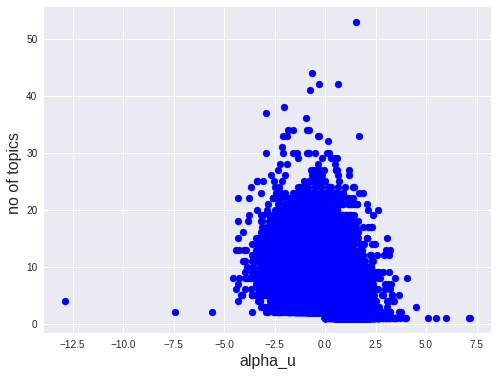

In [46]:
fig = plt.figure()
fig.set_size_inches(8, 6)
#plt.title('Test accuracies across models')

plt.scatter(fb_alphas, ntopic_seq, marker='o', color='b')
plt.ylabel('no of topics ', fontsize = 16)
plt.xlabel('alpha_u', fontsize = 16)
#plt.xticks(range(3), ['Model 3', 'Model 4', 'Model 5'])
plt.legend(loc='best')
#plt.grid(True)
plt.savefig('cor_alphaU_nTopics.png', bbox_inches='tight')

/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


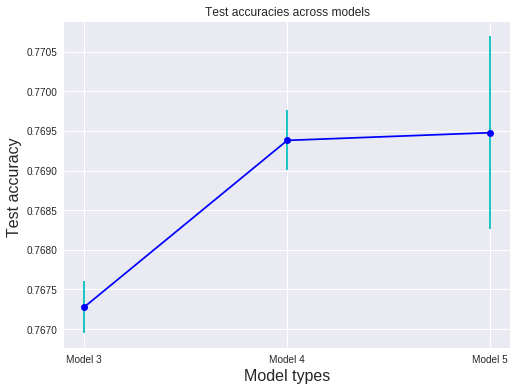

In [11]:
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Test accuracies across models')

plt.errorbar(np.arange(3), [0.76728, 0.76938, 0.76947701], yerr=[0.0003282, 3.772405811783870319e-04, 0.00121321], linestyle='-', marker='o', color='b', ecolor='c')
plt.ylabel('Test accuracy ', fontsize = 16)
plt.xlabel('Model types', fontsize = 16)
plt.xticks(range(3), ['Model 3', 'Model 4', 'Model 5'])
plt.legend(loc='best')
#plt.grid(True)
plt.savefig('accuracies_across_model.png', bbox_inches='tight')

In [12]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)



user_idx = 7212
j=0

data = np.loadtxt('model_parameters_1userTime_TopicTime2.txt')
res = data
N = len(res)
print(N)

no_topics = 100
topic_time_evt_matrix = res[100+7212:25612].flatten().reshape(no_topics, -1)

jan = ['Jan '+str(i+1) for i in range(31)]
feb = ['Feb '+str(i+1) for i in range(29)]
mar = ['Mar '+str(i+1) for i in range(31)]
apr = ['Apr '+str(i+1) for i in range(30)]
may = ['May '+str(i+1) for i in range(31)]
jun = ['Jun '+str(i+1) for i in range(30)]

time_bins = np.array(jan+feb+mar+apr+may+jun)
x_bins = [k for k in range(182) if k%7==0]

imp_topics = [6, 14, 17, 19, 20, 25, 36, 43, 56, 60]  # selected by comparing beta value with topic definition
topic_NoconsEvents = {}
no_topics_with_consEvts = 0
for top in imp_topics:
    
    res = topic_time_evt_matrix[top]
    N = len(res)
    error = np.zeros((N,))

    res_min_error = res - error
    res_min_error[res_min_error<0] = 0
    
    result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
    topic_NoconsEvents[top] = len(result)
    
    
    if len(result) > 0:
        no_topics_with_consEvts+=1
        print(top, np.array(result_idx)+1)
        j+=1
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)
        
    

    autocorr = pearsonr(res[:-1], res[1:])[0]
    #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

    minr = np.min(res)
    maxr = np.max(res)
    fig = plt.figure()
    fig.subplots_adjust(hspace=.50)
    fig.set_size_inches(10, 6)
    plt.subplot(1, 1, 1)
    plt.title(title_name+ ', autocorrelation R='+str(round(autocorr,5)))
    plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
    plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)

    plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
    #plt.stem(list(range(N)), [0]*N, linestyle='-', marker='o', color='r')
    plt.axhline(linewidth=4, color='k')
    #plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
    #plt.plot([2,2], [minr-2, maxr+2], color='k')
    #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.xticks(x_bins, time_bins[x_bins])
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=27)
    plt.legend(loc='best')
    plt.savefig('beta_topic'+str(top)+'.png', bbox_inches='tight')

print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)
#print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
#print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])

OSError: model_parameters_1userTime_TopicTime2.txt not found.

In [13]:
# Logistic regression with the lasso (bootstrap)
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)
# Accuracy metric for the proposed method
bins_per_day = [1,2,3,4,6] 
accuracies = []
std_errors = []
for binc in bins_per_day:
    print(binc)
    data = np.loadtxt('accuracy'+str(binc)+'boot_ut.txt')
    res = data[-2]
    error = data[-1]
    if binc < 3: 
        res = data[2][-2]
        error = data[2][-1]
        
    accuracies.append(res)
    std_errors.append(error)
    

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Model 3 with smoothing:  Accuracy ')

plt.errorbar(bins_per_day, accuracies, yerr=std_errors, linestyle='-', marker='o', color='g', label='with modeling events')
#plt.plot(bins_per_day, [0.755318]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('Training Accuracy ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('chosen_model_accuracy.png', bbox_inches='tight')

exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)
avg_error_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0

per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    data = np.loadtxt('model_parameters_'+str(binc)+'boot_ut0.txt')
    res = data[0]
    res_error = data[1]
    
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[100+7212:].flatten().reshape(no_topics, -1)
    topic_time_evt_matrix_std = res_error[100+7212:].flatten().reshape(no_topics, -1)
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        N = len(res)
        error = topic_time_evt_matrix_std[top]
        print(len(res))
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            #avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            res = np.mean(res, axis=1)
            
            avg_error_bin2[bin2_indexes] = error
            avg_error_bin2[absent_indexes] = avg_error_bin2[new_absent_indexes]
            error = avg_error_bin2.reshape(-1,2)
            error = np.amax(error, axis=1)
            
            N = len(res)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            print("haha")
            per_bin_results.append(res)
            
        
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
        if i==2: continue
        plt.subplot(2, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        #plt.errorplot(res, linestyle='-', marker='o', color='g')
        plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    
   
plt.savefig('model3_beta_lasso_user_topic.png', bbox_inches='tight')

ValueError: invalid literal for int() with base 10: 'percentile'

In [14]:
# Logistic regression with the proposed objective (bootstrap)
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)
avg_error_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0

per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    data = np.loadtxt('model_parameters_'+str(binc)+'boot_ut2.txt')
    res = data[0]
    res_error = data[1]
    
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[100+7212:].flatten().reshape(no_topics, -1)
    topic_time_evt_matrix_std = res_error[100+7212:].flatten().reshape(no_topics, -1)
    
    imp_topics = [14,17, 19, 21, 25, 30, 31, 32, 36, 37, 50, 51, 57, 58, 59, 60, 64, 65,75,76,78,79,86,87,93, 95]
    for top in [93,95]:
        j+=1
        res = topic_time_evt_matrix[top]
        N = len(res)
        error = topic_time_evt_matrix_std[top]
        print(len(res))
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            res = np.mean(res, axis=1)
            
            avg_error_bin2[bin2_indexes] = error
            avg_error_bin2[absent_indexes] = avg_error_bin2[new_absent_indexes]
            error = avg_error_bin2.reshape(-1,2)
            error = np.amax(error, axis=1)
            
            N = len(res)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            print("haha")
            per_bin_results.append(res)
            
        
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
        if i==2: continue
        plt.subplot(2, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        #plt.errorplot(res, linestyle='-', marker='o', color='g')
        plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    
   
plt.savefig('model3_beta_smooth_user_topic.png', bbox_inches='tight')

ValueError: invalid literal for int() with base 10: 'percentile'

In [15]:
# Logistic regression with the proposed objective (bootstrap)
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)
avg_error_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0

per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    data = np.loadtxt('model_parameters_'+str(binc)+'boot_u2.txt')
    res = data[0]
    res_error = data[1]
    
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    topic_time_evt_matrix_std = res_error[7212:].flatten().reshape(no_topics, -1)
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        N = len(res)
        error = topic_time_evt_matrix_std[top]
        print(len(res))
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            res = np.mean(res, axis=1)
            
            avg_error_bin2[bin2_indexes] = error
            avg_error_bin2[absent_indexes] = avg_error_bin2[new_absent_indexes]
            error = avg_error_bin2.reshape(-1,2)
            error = np.amax(error, axis=1)
            
            N = len(res)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            print("haha")
            per_bin_results.append(res)
            
        
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
        if i==2: continue
        plt.subplot(2, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        #plt.errorplot(res, linestyle='-', marker='o', color='g')
        plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    
   
plt.savefig('model3_beta_smooth_user.png', bbox_inches='tight')

ValueError: invalid literal for int() with base 10: 'percentile'

In [16]:
# Logistic regression with Lasso: beta_1 value
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2,3,4,6]

res_base = np.loadtxt('model_parameters_b.txt')

betas_1 = []
baseline =  res_base[0]               
for binc in bins_per_day:
    res = np.loadtxt('model_parameters_'+str(binc)+'.txt')
    betas_1.append(res[0])

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Logit with Lasso: Fitted value for Feedback')

plt.plot(bins_per_day, betas_1, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [baseline]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('feedback, ' r' $\alpha_1$', fontsize = 16)
plt.legend(loc='best')
plt.savefig('model_betas_M1.png', bbox_inches='tight')

OSError: model_parameters_b.txt not found.

In [16]:
# compute standard error
def get_standardError(data, alpha=0.05):
    stat_rt_data = np.sort(data, axis=0)
    num_samples = len(data)
    low_conf_rt_data = stat_rt_data[int((alpha / 2.0) * num_samples)]
    high_conf_rt_data = stat_rt_data[int((1 - alpha / 2.0) * num_samples)]
    rt_data_error = (high_conf_rt_data - low_conf_rt_data) / 2.0

    return rt_data_error

No handles with labels found to put in legend.


Non-zero features:  25459


No handles with labels found to put in legend.


Non-zero features:  43357


No handles with labels found to put in legend.


Non-zero features:  61457


No handles with labels found to put in legend.


Non-zero features:  79361


No handles with labels found to put in legend.


Non-zero features:  114112


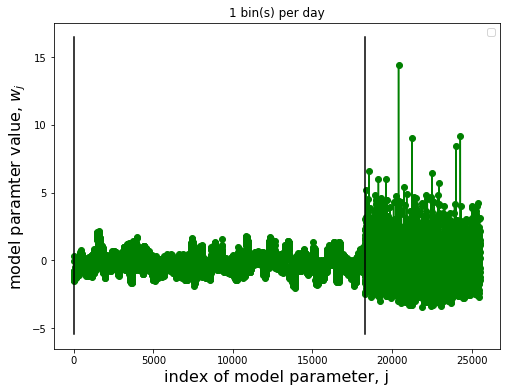

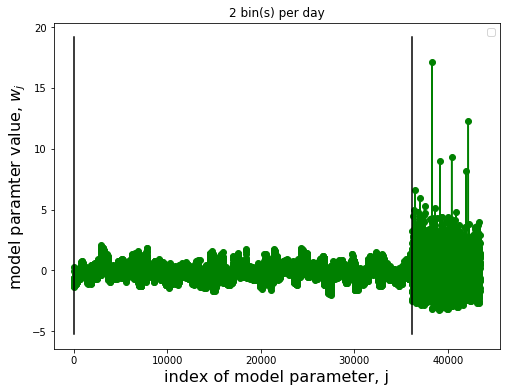

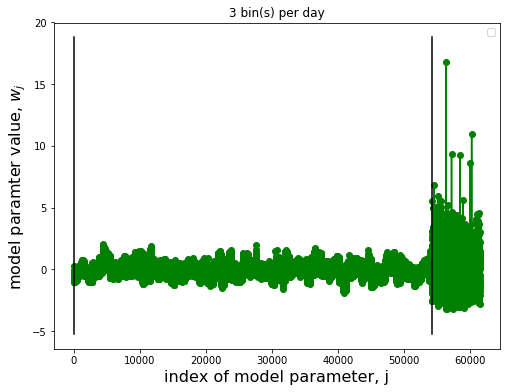

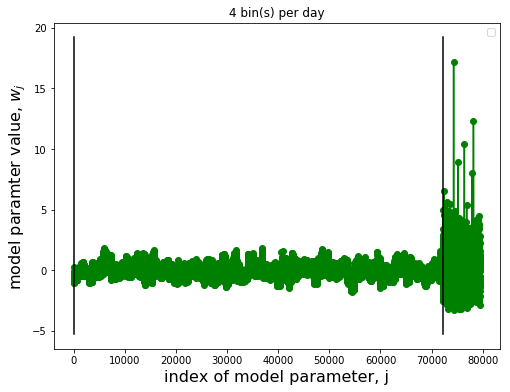

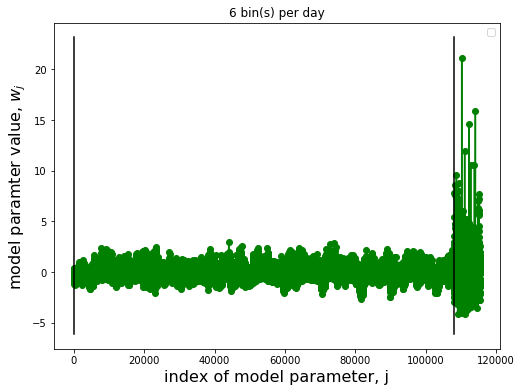

In [17]:
# Proposed Objective function
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2,3,4,6]

user_idx = 7212
for binc in bins_per_day:
    res = np.loadtxt('model_parameters_'+str(binc)+'s.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    resA = res[user_idx:]
    resB = res[2:user_idx]
    res = np.concatenate((res[:2], resA, resB))
    N = len(res)
    
    minr = np.min(res)
    maxr = np.max(res)
    
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.title(str(binc)+' bin(s) per day')

    plt.plot(res, linestyle='-', marker='o', color='g')
    plt.plot([2,2], [minr-2, maxr+2], color='k')
    plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.ylabel('model paramter value, ' r'$w_j$', fontsize = 16)
    plt.xlabel('index of model parameter, 'r'j', fontsize = 16)
    plt.legend(loc='best')
    plt.savefig('model_betas_'+str(binc)+'mbins_per_day.png', bbox_inches='tight')

[0.2994493005408749, 0.2727115826532283, 0.2637505333516687, 0.2335682844992853, 0.2747031787447318, 0.2720133867019029, 0.26974067785164524]


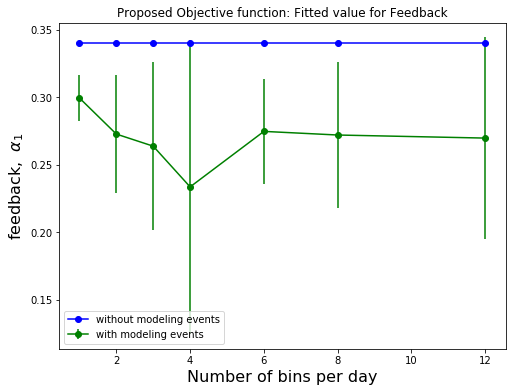

In [18]:
# Proposed Objective function: beta_1 value
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2,3,4,6, 8, 12]

res_base = np.loadtxt('model_parameters_bsplit.txt')

betas_1 = []
std_errors = []
baseline =  res_base[0]               
for binc in bins_per_day:
    data = np.loadtxt('model_parameters_'+str(binc)+'boot.txt')
    res = np.mean(data[:,0])
    betas_1.append(res)
    error = get_standardError(data[:,0]) 
    std_errors.append(error)

print(betas_1)
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Proposed Objective function: Fitted value for Feedback')

plt.errorbar(bins_per_day, betas_1, yerr = std_errors, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [baseline]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('feedback, ' r' $\alpha_1$', fontsize = 16)
plt.legend(loc='best')
plt.savefig('model_betas_M2.png', bbox_inches='tight')

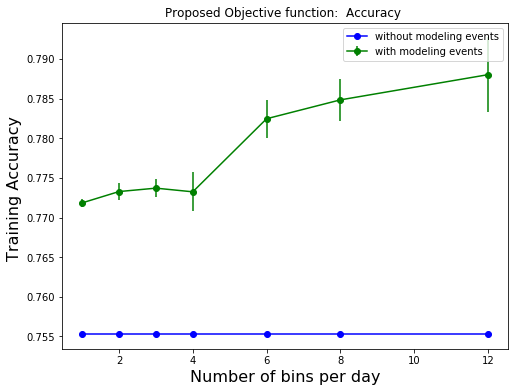

In [19]:
# Accuracy metric for the proposed method
bins_per_day = [1,2,3,4,6, 8, 12] 
#accuracies = [0.771432, 0.773625, 0.775621, 0.776912, 0.778454]
#accuracies = [0.77091, 0.77174, 0.77187, 0.771558, 0.77588]
#accuracies = [0.771234, 0.77357, 0.7750, 0.7752, 0.7764]
accuracies = []
std_errors = []
baseline =  res_base[0]               
for binc in bins_per_day:
    data = np.loadtxt('accuracy'+str(binc)+'boot.txt')
    res = np.mean(data)
    accuracies.append(res)
    error = 1.96*np.std(data)#get_standardError(data[:,0]) 
    std_errors.append(error)
    

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Proposed Objective function:  Accuracy ')

plt.errorbar(bins_per_day, accuracies, yerr=std_errors, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [0.755318]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('Training Accuracy ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('model_betas_accuracy.png', bbox_inches='tight')

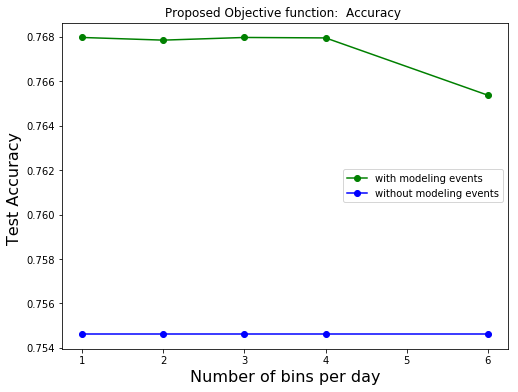

In [20]:
# Accuracy metric for the proposed method
bins_per_day = [1,2,3,4,6] 
#accuracies = [0.76834, 0.76824, 0.76707, 0.76641, 0.76592]
accuracies = [0.76797, 0.76785, 0.76797, 0.76795, 0.76537]

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Proposed Objective function:  Accuracy ')

plt.plot(bins_per_day, accuracies, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [0.7546257]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('Test Accuracy ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('model_betas_test_accuracy.png', bbox_inches='tight')

No handles with labels found to put in legend.


Non-zero features:  25147


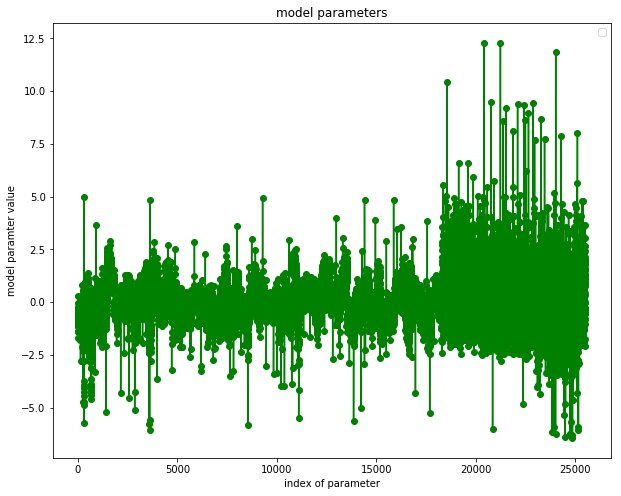

In [21]:
res = np.loadtxt('model_parameters_1bcv.txt')
print('Non-zero features: ', len(np.where(res!=0)[0]))
fig = plt.figure()
fig.set_size_inches(10, 8)
plt.title('model parameters')

plt.plot(res, linestyle='-', marker='o', color='g')
plt.ylabel('model paramter value')
plt.xlabel('index of parameter')
plt.legend(loc='best')
plt.savefig('model_beta.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  23827
25512
183
correlation (binc, topic, autocorrelation): (1, 0, 0.642477) 
183
correlation (binc, topic, autocorrelation): (1, 1, 0.840268) 
Non-zero features:  38317
43412
362
correlation (binc, topic, autocorrelation): (2, 0, 0.538989) 
362
correlation (binc, topic, autocorrelation): (2, 1, 0.383350) 
Non-zero features:  38317
43412
183
correlation (binc, topic, autocorrelation): (2, 0, 0.741665) 
183
correlation (binc, topic, autocorrelation): (2, 1, 0.576540) 
correlation between 1bin_perday, 2bins_perday, topic 1  0.3679695805059211
correlation between 1bin_perday, 2bins_perday, topic 2  -0.022302287869793158


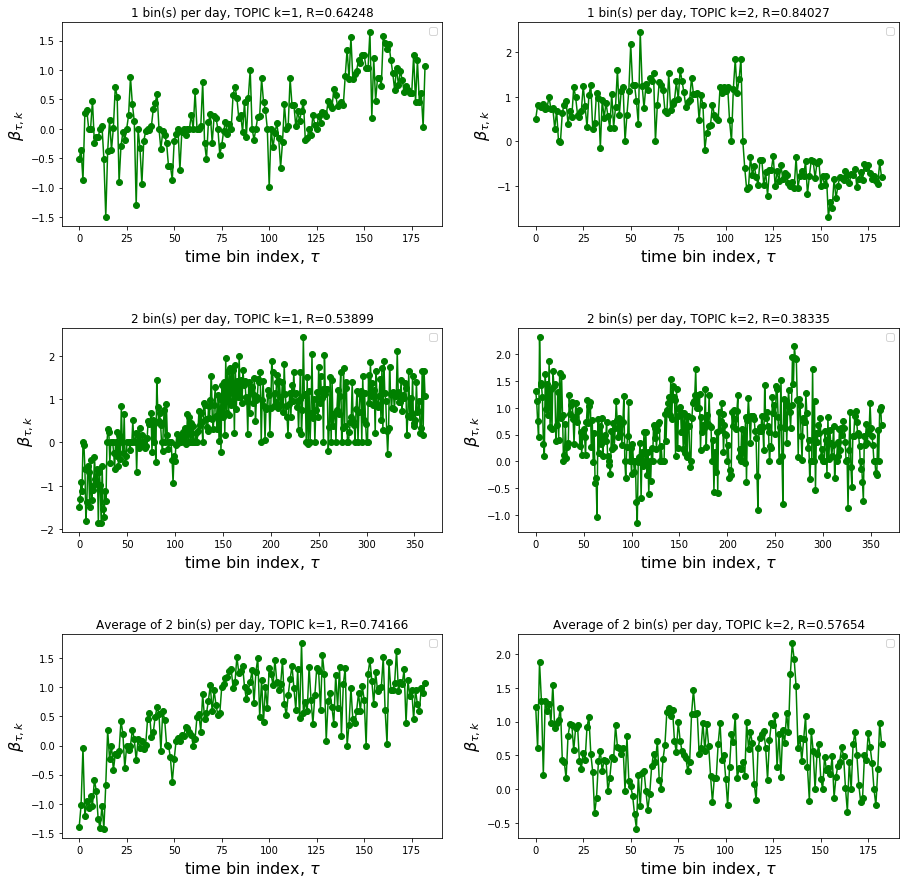

In [22]:
# Logistic regression with Lasso


with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0
per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    
    res = np.loadtxt('model_parameters_'+str(binc)+'.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            #print(res)
            res = np.mean(res, axis=1)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            per_bin_results.append(res)
        
        print(len(res))
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
    
        plt.subplot(3, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        plt.plot(res, linestyle='-', marker='o', color='g')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    

'''
for binc in bins_per_day:
    res = np.loadtxt('model_parameters_'+str(binc)+'.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))
        minr = np.min(res)
        maxr = np.max(res)
    
        plt.subplot(2, 2, j)
        plt.title(str(binc)+' bin(s) per day, TOPIC k='+str(top+1)+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        plt.plot(res, linestyle='-', marker='o', color='g')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
'''    
    
plt.savefig('model_betas_perTopic_lasso.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  23827
25512
183
correlation (binc, topic, autocorrelation): (1, 0, 0.642477) 
183
correlation (binc, topic, autocorrelation): (1, 1, 0.840268) 
Non-zero features:  38317
43412
362
correlation (binc, topic, autocorrelation): (2, 0, 0.538989) 
362
correlation (binc, topic, autocorrelation): (2, 1, 0.383350) 
Non-zero features:  38317
43412
183
correlation (binc, topic, autocorrelation): (2, 0, 0.741665) 
183
correlation (binc, topic, autocorrelation): (2, 1, 0.576540) 


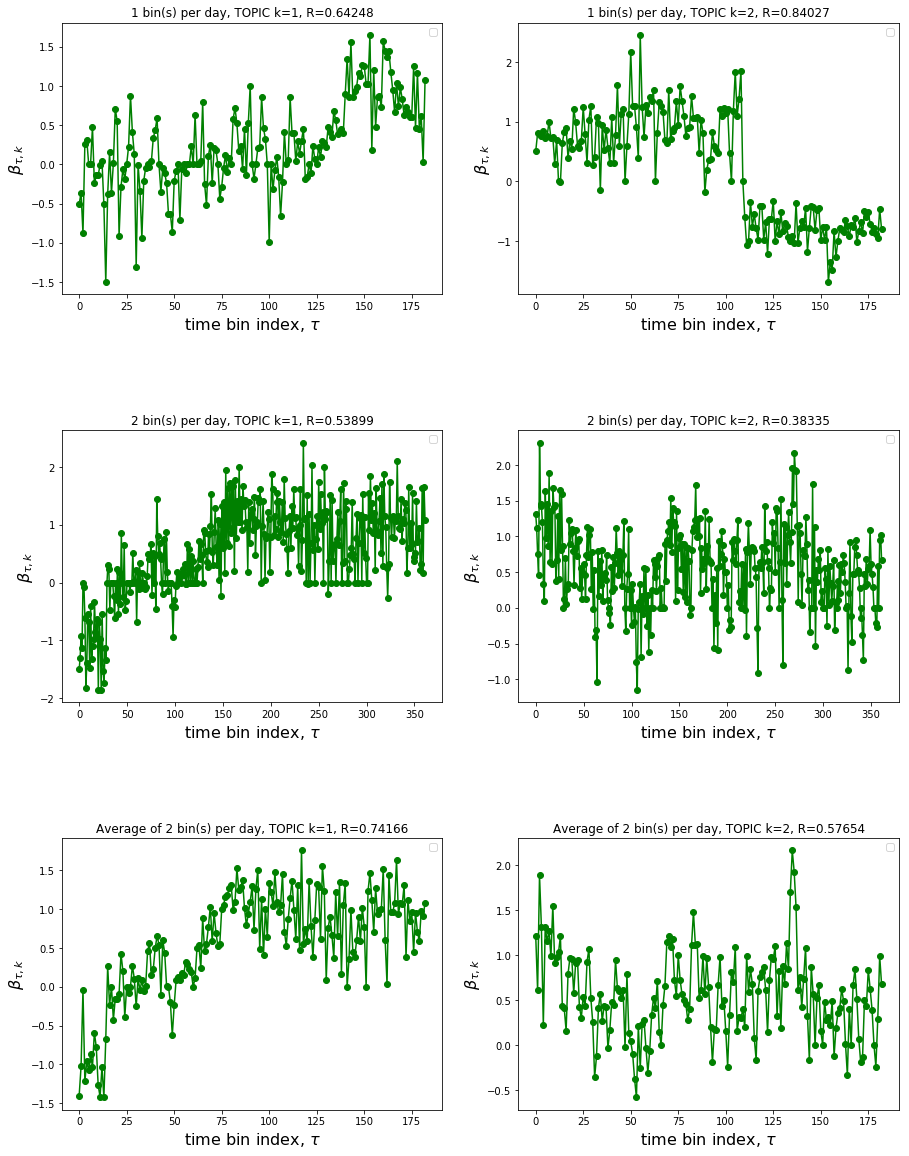

In [23]:
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 20)

user_idx = 7212
j=0
for i, binc in enumerate(bins_per_day):
    
    res = np.loadtxt('model_parameters_'+str(binc)+'.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            #print(res)
            res = np.mean(res, axis=1)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        print(len(res))
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
    
        plt.subplot(3, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        plt.plot(res, linestyle='-', marker='o', color='g')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
    
plt.savefig('model_betas_perTopic_lasso.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  25459
25512
183
correlation (binc, topic, autocorrelation): (1, 0, 0.803493) 
183
correlation (binc, topic, autocorrelation): (1, 1, 0.878579) 
Non-zero features:  43357
43412
362
correlation (binc, topic, autocorrelation): (2, 0, 0.890711) 
362
correlation (binc, topic, autocorrelation): (2, 1, 0.891088) 


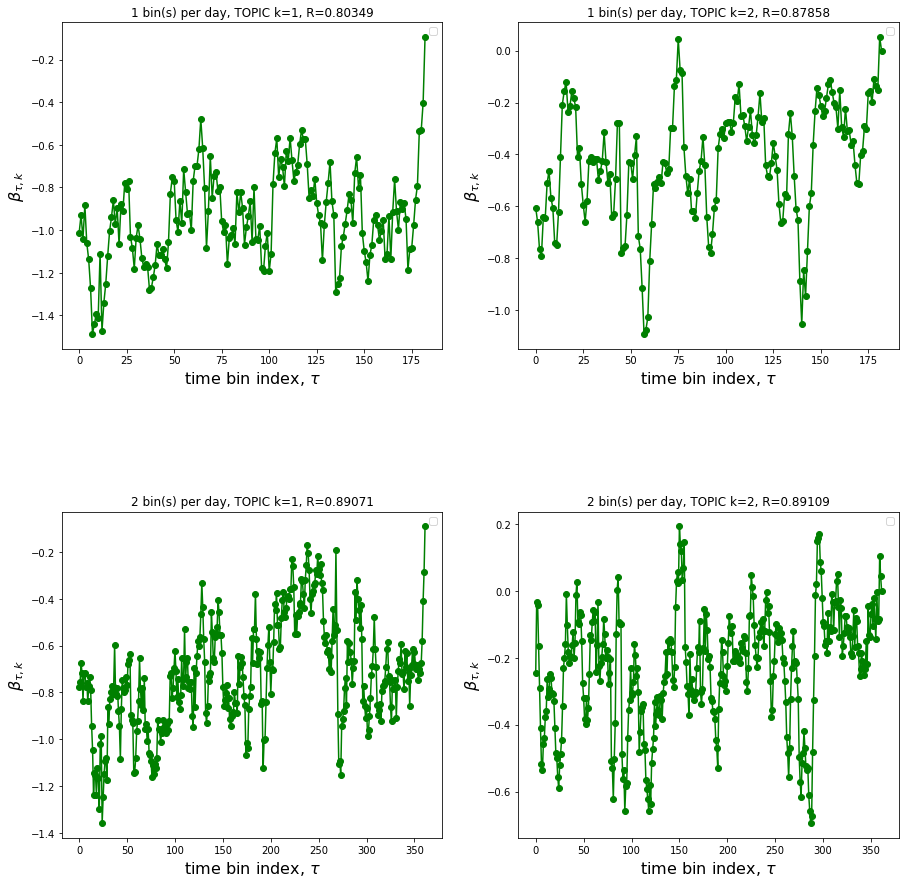

In [24]:
# Logistic regression with the proposed objective
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0
for binc in bins_per_day:
    res = np.loadtxt('model_parameters_'+str(binc)+'s.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        print(len(res))
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
    
        plt.subplot(2, 2, j)
        plt.title(str(binc)+' bin(s) per day, TOPIC k='+str(top+1)+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        plt.plot(res, linestyle='-', marker='o', color='g')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
    
plt.savefig('model_betas_perTopic_proposed.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  25459
25512
183
correlation (binc, topic, autocorrelation): (1, 0, 0.803493) 
183
correlation (binc, topic, autocorrelation): (1, 1, 0.878579) 
Non-zero features:  43357
43412
362
correlation (binc, topic, autocorrelation): (2, 0, 0.890711) 
362
correlation (binc, topic, autocorrelation): (2, 1, 0.891088) 


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  43357
43412
183
correlation (binc, topic, autocorrelation): (2, 0, 0.842256) 
183
correlation (binc, topic, autocorrelation): (2, 1, 0.795762) 
correlation between 1bin_perday, 2bins_perday, topic 1  0.7995575264269742
correlation between 1bin_perday, 2bins_perday, topic 2  0.8060712886082467


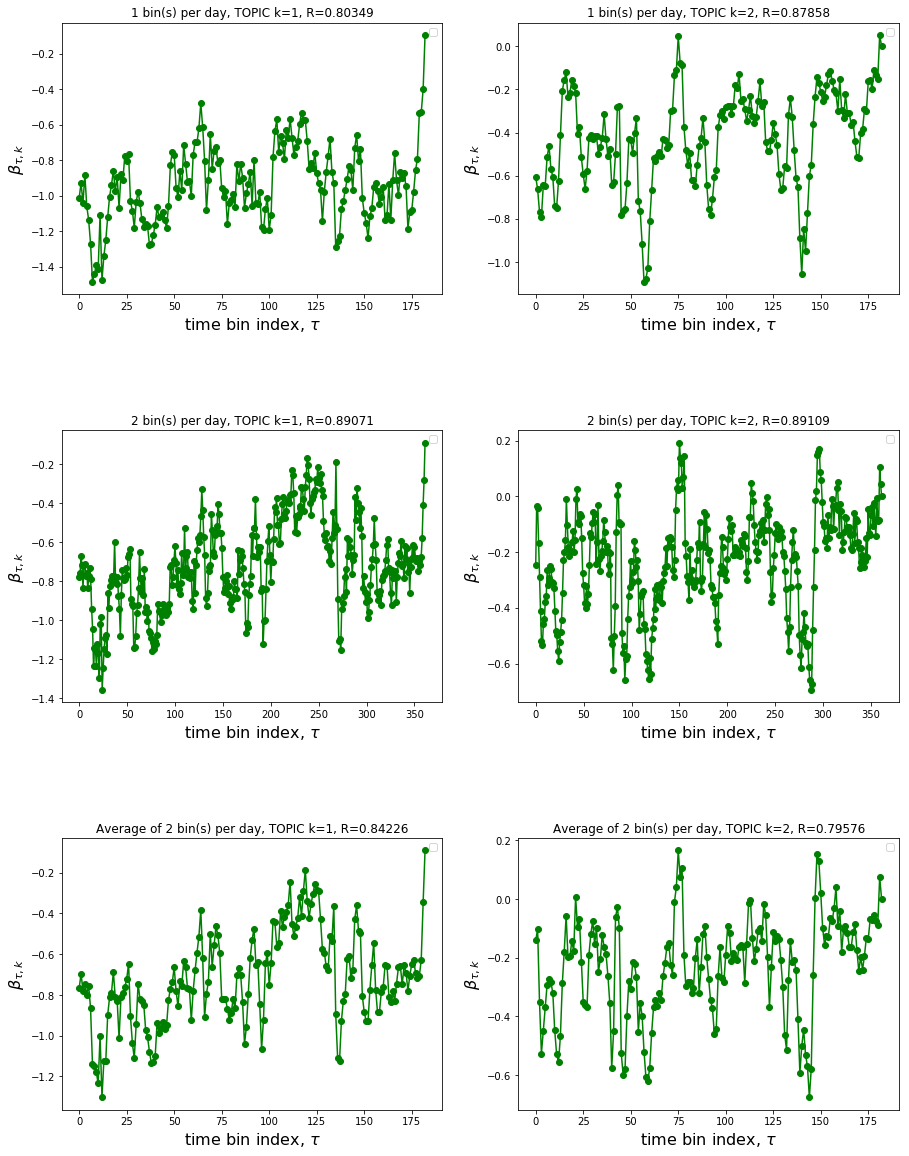

In [25]:
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 20)

user_idx = 7212
j=0

per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    
    res = np.loadtxt('model_parameters_'+str(binc)+'s.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            #print(res)
            res = np.mean(res, axis=1)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            per_bin_results.append(res)
        
        print(len(res))
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
    
        plt.subplot(3, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        plt.plot(res, linestyle='-', marker='o', color='g')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    

plt.savefig('model_betas_perTopic_proposed.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


beta_1 parameter (feedback) : 0.2994493005408749
beta_1 parameter std : 0.020831339540292634
183
haha
correlation (binc, topic, autocorrelation): (1, 0, 0.740621) 
183
haha
correlation (binc, topic, autocorrelation): (1, 1, 0.875013) 


No handles with labels found to put in legend.
No handles with labels found to put in legend.


beta_1 parameter (feedback) : 0.2727115826532283
beta_1 parameter std : 0.05083695421080387
362
correlation (binc, topic, autocorrelation): (2, 0, 0.849299) 
362
correlation (binc, topic, autocorrelation): (2, 1, 0.887531) 
beta_1 parameter (feedback) : 0.2727115826532283
beta_1 parameter std : 0.05083695421080387
362
haha
correlation (binc, topic, autocorrelation): (2, 0, 0.782603) 
362
haha
correlation (binc, topic, autocorrelation): (2, 1, 0.794199) 
correlation between 1bin_perday, 2bins_perday, topic 1  0.8959734509852737
correlation between 1bin_perday, 2bins_perday, topic 2  0.9331902219680274


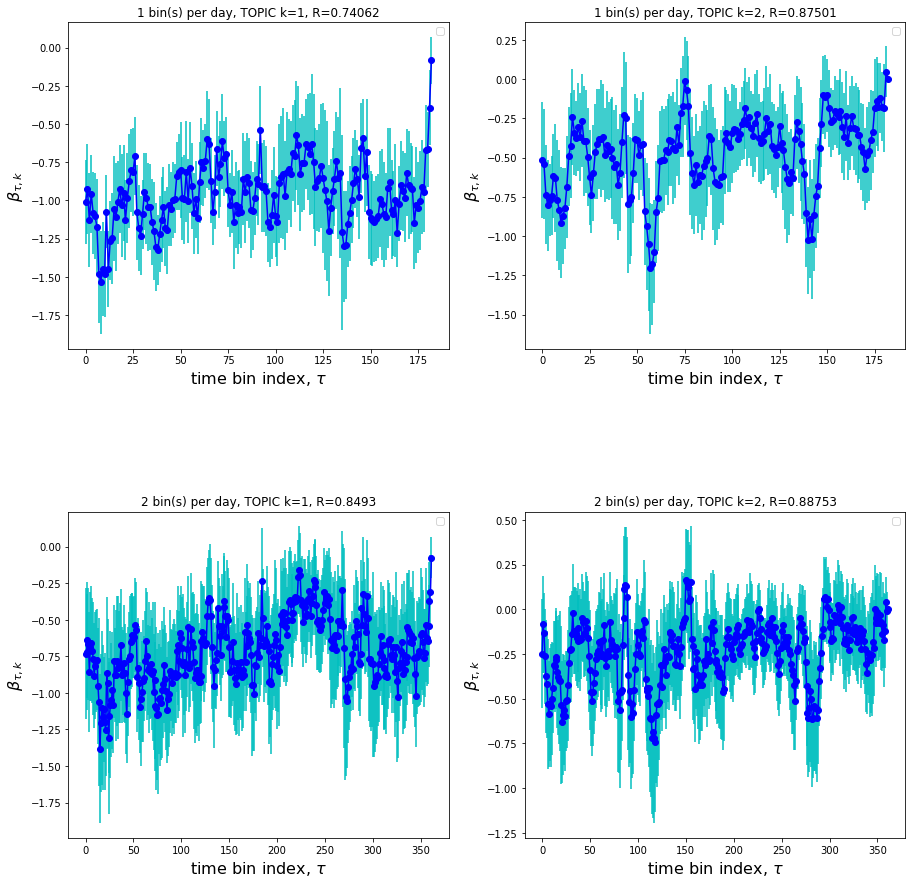

In [26]:
# Logistic regression with the proposed objective (bootstrap)
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)
avg_error_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0

per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    data = np.loadtxt('model_parameters_'+str(binc)+'boot.txt')
    n_bootstrap = data.shape[0]
    print('beta_1 parameter (feedback) :', np.mean(data[:,0]))
    print('beta_1 parameter std :', 1.96*np.std(data[:,0]))
    
    no_topics = 100
    topic_time_evt_matrix = data[:,7212:].flatten().reshape(n_bootstrap, no_topics, -1)
    
    topic_time_evt_matrix_mean = np.mean(topic_time_evt_matrix, axis=0)
    topic_time_evt_matrix_std = get_standardError(topic_time_evt_matrix)
    #print(topic_time_evt_matrix_std[:10])
    #print(np.std(topic_time_evt_matrix, axis=0)[:10])
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix_mean[top]
        N = len(res)
        error = topic_time_evt_matrix_std[top]
        print(len(res))
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            res = np.mean(res, axis=1)
            
            avg_error_bin2[bin2_indexes] = error
            avg_error_bin2[absent_indexes] = avg_error_bin2[new_absent_indexes]
            error = avg_error_bin2.reshape(-1,2)
            error = np.mean(error, axis=1)
            
            N = len(res)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            print("haha")
            per_bin_results.append(res)
            
        
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
        if i==2: continue
        plt.subplot(2, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        #plt.errorplot(res, linestyle='-', marker='o', color='g')
        plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    
   
plt.savefig('model_betas_perTopic_proposed_boot.png', bbox_inches='tight')

In [27]:
"""l-bfgs-b L1-Logistic Regression solver"""

# Author: Vlad Niculae <vlad@vene.ro>
# Suggested by Mathieu Blondel

from __future__ import division, print_function

import numpy as np
from scipy.optimize import fmin_l_bfgs_b

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.extmath import safe_sparse_dot, log_logistic
#from sklearn.utils.fixes import expit
from scipy.special import expit
from sklearn import grid_search
from scipy.sparse import csr_matrix

        
def _l1_logistic_loss_grad(w_extended, X, y, alpha, k, idx):
    #print(k)
    _, n_features = X.shape
    w = w_extended[:n_features] - w_extended[n_features:]

    yz = y * safe_sparse_dot(X, w)

    # Logistic loss is the negative of the log of the logistic function.
    out = -np.sum(log_logistic(yz))
    # out += .5 * alpha * np.dot(w, w)  # L2
    
    #w_extended[0:2]=0.
    #w_extended[n_features:n_features+2]=0.
    w_ = w[idx:]
    w_= np.transpose(w_.flatten().reshape(k,-1))
    #print(w_.shape)
    D = w_[1:,:]-w_[:-1,:]
    zero = np.zeros((1, k))
    
    D = np.concatenate((D, zero), axis=0)
    D = D.flatten()
    
    #out += alpha * w_extended.sum()
    out += alpha * w_extended.sum() + D.sum() # L1, w_extended is non-negative

    z = expit(yz)
    z0 = (z - 1) * y

    grad = safe_sparse_dot(X.T, z0)
    grad = np.concatenate([grad, -grad])

    # grad += alpha * w  # L2
    #grad += alpha  # L1
    D_grad = np.zeros((n_features,))
    D_grad[idx:] = D
    D_grad = np.concatenate([D_grad, -D_grad])
    grad += alpha + 2*D_grad
    #print(grad.shape)

    return out, grad

class LbfgsL1Logistic(BaseEstimator, ClassifierMixin):

    def __init__(self, tol=1e-3, alpha=1.0):
        """Logistic Regression Lasso solved by L-BFGS-B
        Solves the same objective as sklearn.linear_model.LogisticRegression
        Parameters
        ----------
        alpha: float, default: 1.0
            The amount of regularization to use.
        tol: float, default: 1e-3
            Convergence tolerance for L-BFGS-B.
        """
        self.tol = tol
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape
        k = 4
        idx=20

        coef0 = np.zeros(2 * n_features)
        w, f, d = fmin_l_bfgs_b(_l1_logistic_loss_grad, x0=coef0, fprime=None,
                                pgtol=self.tol,
                                bounds=[(0, None)] * n_features * 2,
                                args=(X, y, self.alpha, k, idx))
        self.coef_ = w[:n_features] - w[n_features:]

        return self

    def predict(self, X):
        return np.sign(safe_sparse_dot(X, self.coef_))


if __name__ == '__main__':
    from scipy.spatial.distance import jaccard
    from sklearn.linear_model import LogisticRegression
    from time import time

    # Generate data with known sparsity pattern
    n_samples, n_features, n_relevant = 100, 80, 20
    X = np.random.randn(n_samples, n_features)
    X /= np.linalg.norm(X, axis=1)[:, np.newaxis]
    true_coef = np.zeros(n_features)
    nonzero_idx = np.random.randint(n_features, size=n_relevant)
    true_coef[nonzero_idx] = np.random.randn(n_relevant)
    y = np.dot(X, true_coef) + np.random.randn(n_samples) * 0.01
    # classification, note: y must be {-1, +1}
    
    X = csr_matrix(X)
    y = np.sign(y)    

    C = 1.0
    
    parameters = {'alpha':[0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}
        
    # Run this solver
    t0 = time()
    lasso_1_ = LbfgsL1Logistic(alpha=1. / C, tol=1e-8)
    lasso_1_ = grid_search.GridSearchCV(lasso_1_, parameters)
    lasso_1_.fit(X, y)
    print('')
    lasso_1 = lasso_1_.best_estimator_
    #lasso_1 = LbfgsL1Logistic(alpha=lasso_1_.best_params_['alpha'], tol=1e-8)
    #lasso_1.fit(X, y)
    
    t0 = time() - t0
    print("l-bfgs-b:  time = {:.4f}s acc = {:.8f}  ||w - w_true|| = {:.6f}  "
          "Jacc. sparsity = {:.2f}".format(t0, lasso_1.score(X, y),
            np.linalg.norm(lasso_1.coef_ - true_coef),
            jaccard(true_coef > 0, lasso_1.coef_ > 0)))

    # run liblinear
    t0 = time()
    lasso_2 = LogisticRegression(penalty='l1', C=C, tol=1e-8,
                                 fit_intercept=False).fit( X, y)
    t0 = time() - t0
    print("liblinear: time = {:.4f}s acc = {:.8f}  ||w - w_true|| = {:.6f}  "
          "Jacc. sparsity = {:.2f}".format(t0, lasso_2.score(X, y),
            np.linalg.norm(lasso_2.coef_ - true_coef),
            jaccard(true_coef > 0, lasso_2.coef_ > 0)))

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)



l-bfgs-b:  time = 0.1888s acc = 0.92000000  ||w - w_true|| = 4.664474  Jacc. sparsity = 0.64
liblinear: time = 0.0010s acc = 0.87000000  ||w - w_true|| = 6.554381  Jacc. sparsity = 0.70


\begin{equation}
y_i = \sigma \left(\alpha_1 T_i + \alpha_2 \Delta t_i + \sum_{\tau=0}^{B}  \sum_{k=0}^{100} \delta_{\tau_i \tau} \delta_{k_i k}  \beta_{\tau k} + \sum_{k=0}^{100} \gamma_k \delta_{k k_i} \right)
\label{eq:model_logit}
\end{equation}

No handles with labels found to put in legend.


Non-zero features:  18347


No handles with labels found to put in legend.


Non-zero features:  30294


No handles with labels found to put in legend.


Non-zero features:  44413


No handles with labels found to put in legend.


Non-zero features:  56761


No handles with labels found to put in legend.


Non-zero features:  74270


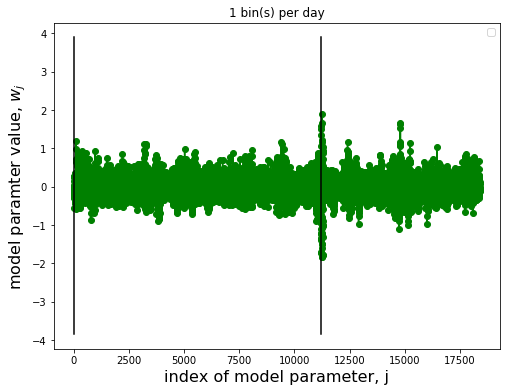

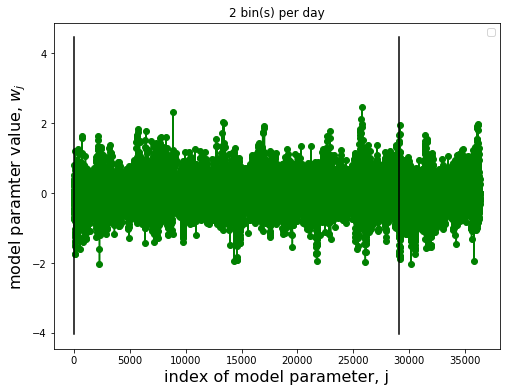

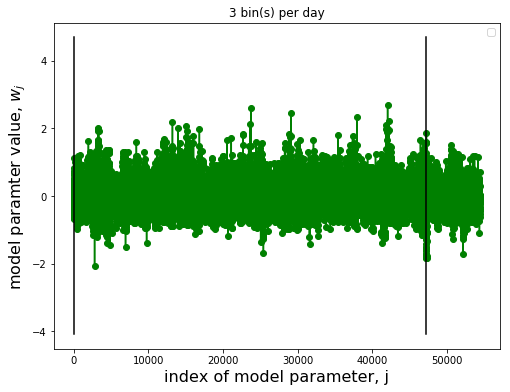

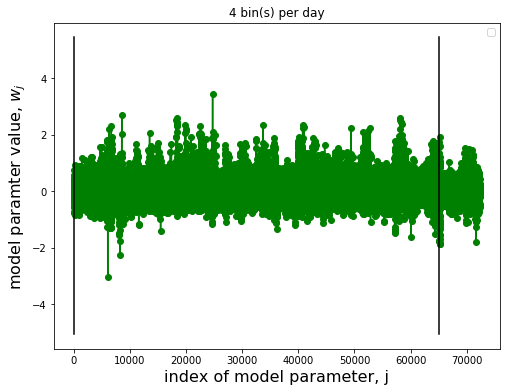

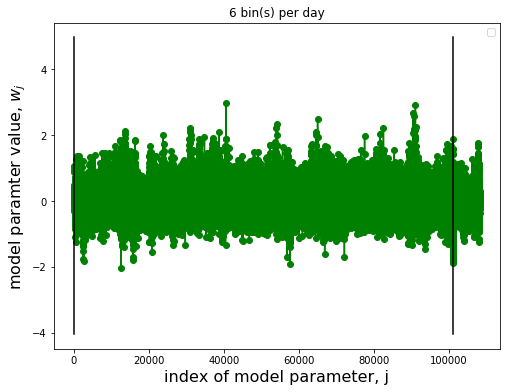

In [28]:
# Proposed Objective function
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2,3,4,6]

user_idx = 7212
for binc in bins_per_day:
    res = np.loadtxt('model_parameters_'+str(binc)+'t.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    resA = res[user_idx:]
    resB = res[2:user_idx]
    res = np.concatenate((res[:2], resA, resB))
    N = len(res)
    
    minr = np.min(res)
    maxr = np.max(res)
    
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.title(str(binc)+' bin(s) per day')

    plt.plot(res, linestyle='-', marker='o', color='g')
    plt.plot([2,2], [minr-2, maxr+2], color='k')
    plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.ylabel('model paramter value, ' r'$w_j$', fontsize = 16)
    plt.xlabel('index of model parameter, 'r'j', fontsize = 16)
    plt.legend(loc='best')
    plt.savefig('model_betas_'+str(binc)+'mbins_per_day_topic.png', bbox_inches='tight')

[0.24309355646920378, 0.23361919962290695, 0.23097130268413185, 0.2313521982141153, 0.22817882502688738]


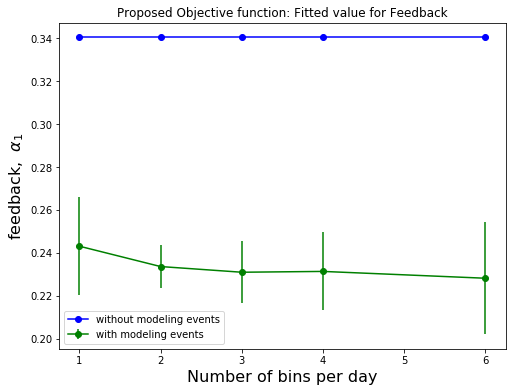

In [29]:
# Proposed Objective function: beta_1 value (topic control)
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2,3,4,6]

res_base = np.loadtxt('model_parameters_bsplit.txt')

betas_1 = []
std_errors = []
baseline =  res_base[0]               
for binc in bins_per_day:
    data = np.loadtxt('model_parameters_'+str(binc)+'t_boot.txt')
    res = np.mean(data[:,0])
    betas_1.append(res)
    error = get_standardError(data[:,0]) 
    std_errors.append(error)

print(betas_1)
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Proposed Objective function: Fitted value for Feedback')

plt.errorbar(bins_per_day, betas_1, yerr = std_errors, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [baseline]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('feedback, ' r' $\alpha_1$', fontsize = 16)
plt.legend(loc='best')
plt.savefig('model_betas_M2_topic.png', bbox_inches='tight')